In [1]:
import pandas as pd

# Define path to TX (Maximum Temperature) file
file_path = '/Users/herambjadhav/Downloads/Heathrow/TX_SOUID105838.txt'  # Replace with actual path

# Load using fixed width
tx_df = pd.read_fwf(file_path, header=None, names=['STAID', 'SOUID', 'DATE', 'TX', 'QFLAG', 'MFLAG'])

# Parse date and filter bad values
tx_df['DATE'] = pd.to_datetime(tx_df['DATE'], format='%Y%m%d')
tx_df['TX'] = tx_df['TX'].replace(-9999, pd.NA) / 10  # Convert to degrees Celsius

# View the first few rows
print(tx_df.head())


                                               STAID  SOUID DATE  TX  QFLAG  \
0  EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D),...    NaN  NaT NaN    NaN   
1  THESE DATA CAN BE USED FREELY PROVIDED THAT TH...    NaN  NaT NaN    NaN   
2  Klein Tank, A.M.G. and Coauthors, 2002. Daily ...    NaN  NaT NaN    NaN   
3  air temperature and precipitation series for t...    NaN  NaT NaN    NaN   
4               Int. J. of Climatol., 22, 1441-1453.    NaN  NaT NaN    NaN   

   MFLAG  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  


In [5]:
import pandas as pd

def load_ecad_file_clean(file_path, variable_name):
    # Step 1: Detect first line of actual data (starts with station ID, usually digits)
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data_start_line = next(i for i, line in enumerate(lines) if line.strip()[:1].isdigit())

    # Step 2: Load data using fixed-width format
    df = pd.read_fwf(
        file_path,
        skiprows=data_start_line,
        header=None,
        names=['STAID', 'SOUID', 'DATE', variable_name, 'QFLAG', 'MFLAG']
    )

    # Step 3: Parse and clean
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d', errors='coerce')
    df[variable_name] = df[variable_name].replace(-9999, pd.NA) / 10

    return df[['DATE', variable_name]]

# Example usage
file_path = '/Users/herambjadhav/Downloads/Heathrow/TX_SOUID105838.txt'
tx_df = load_ecad_file_clean(file_path, 'TX')

print(tx_df.head())


  DATE  TX
0  NaT NaN
1  NaT NaN
2  NaT NaN
3  NaT NaN
4  NaT NaN


In [6]:
with open(file_path, 'r') as f:
    for i, line in enumerate(f.readlines()[:30]):
        print(f"{i}: {line.strip()}")


0: EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 30-03-2025
1: THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:
2: 
3: Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
4: air temperature and precipitation series for the European Climate Assessment.
5: Int. J. of Climatol., 22, 1441-1453.
6: Data and metadata available at http://www.ecad.eu
7: 
8: FILE FORMAT (MISSING VALUE CODE IS -9999):
9: 
10: 01-06 SOUID: Source identifier
11: 08-15 DATE : Date YYYYMMDD
12: 17-21 TX   : maximum temperature in 0.1 &#176;C
13: 23-27 Q_TX : Quality code for TX (0='valid'; 1='suspect'; 9='missing')
14: 
15: This is the series of UNITED KINGDOM, HEATHROW (SOUID: 105838)
16: See file sources.txt for more info.
17: 
18: 
19: 
20: SOUID,    DATE,   TX, Q_TX
21: 105838,19790101,   23,    0
22: 105838,19790102,   16,    0
23: 105838,19790103,   13,    0
24: 105838,19790104,   -3,    0
25: 105838,19790105,   56,    0
26: 105838,197

In [9]:
import pandas as pd

# File path to your Heathrow TX file
file_path = '/Users/herambjadhav/Downloads/Heathrow/TX_SOUID105838.txt'

# Skip 21 rows to bypass metadata AND the column header in row 21
df_tx = pd.read_csv(
    file_path,
    skiprows=21,
    names=['SOUID', 'DATE', 'TX', 'Q_TX']
)

# Parse DATE and clean TX
df_tx['DATE'] = pd.to_datetime(df_tx['DATE'], format='%Y%m%d', errors='coerce')
df_tx['TX'] = df_tx['TX'].replace(-9999, pd.NA) / 10  # °C

# Preview
print(df_tx.head())


    SOUID       DATE   TX  Q_TX
0  105838 1979-01-01  2.3     0
1  105838 1979-01-02  1.6     0
2  105838 1979-01-03  1.3     0
3  105838 1979-01-04 -0.3     0
4  105838 1979-01-05  5.6     0


In [10]:
import pandas as pd
import os

# 🔧 Directory where your Heathrow files are stored
data_dir = '/Users/herambjadhav/Downloads/Heathrow'

# 🗃️ Files to ignore (metadata, reference, non-variable)
exclude_files = {'elements.txt', 'metadata.txt', 'sources.txt'}

# 📦 Container for each variable’s dataframe
variable_dfs = []

# 🔁 Loop through each data file
for file_name in os.listdir(data_dir):
    if file_name.endswith('.txt') and file_name not in exclude_files:
        file_path = os.path.join(data_dir, file_name)
        
        # Dynamically extract the variable name from file (e.g., TX from TX_SOUIDxxxxx.txt)
        variable_code = file_name.split('_')[0]

        # 🧹 Read and clean the file
        df = pd.read_csv(
            file_path,
            skiprows=21,
            names=['SOUID', 'DATE', variable_code, f'Q_{variable_code}']
        )
        df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d', errors='coerce')
        df[variable_code] = df[variable_code].replace(-9999, pd.NA) / 10

        # 👇 Keep only DATE + variable column
        variable_dfs.append(df[['DATE', variable_code]])

# 🔗 Merge all dataframes on DATE
from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='outer'), variable_dfs)

# 🧠 Optional: Sort by date
merged_df.sort_values('DATE', inplace=True)

# ✅ Final Preview
print(merged_df.head())


        DATE      PP   TG   SS   RR   TX   SD   QQ   CC   TN   HU
0 1979-01-01  1019.0 -4.1  7.0  0.4  2.3  0.9  5.2  0.2 -7.5  8.3
1 1979-01-02  1025.3 -2.6  1.7  0.0  1.6  0.8  2.7  0.6 -7.5  7.6
2 1979-01-03  1020.5 -2.8  0.0  0.0  1.3  0.4  1.3  0.5 -7.2  8.6
3 1979-01-04  1008.4 -2.6  0.0  0.0 -0.3  0.2  1.3  0.8 -6.5  6.8
4 1979-01-05  1022.5 -0.8  2.0  0.0  5.6  0.1  2.9  0.6 -1.4  7.3


In [11]:
merged_df.to_csv('/Users/herambjadhav/Downloads/heathrow_merged_weather_data.csv', index=False)


In [17]:
import pandas as pd

# Load Heathrow Daily Data from ECA&D (1979–2024)
heathrow_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_merged_weather_data.csv', parse_dates=['DATE'])
print("📦 Heathrow ECA&D DataFrame Loaded")
print("Shape:", heathrow_df.shape)
print("Date Range:", heathrow_df['DATE'].min(), "to", heathrow_df['DATE'].max())
print(heathrow_df.info())
print(heathrow_df.head())


📦 Heathrow ECA&D DataFrame Loaded
Shape: (16802, 11)
Date Range: 1979-01-01 00:00:00 to 2024-12-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16802 entries, 0 to 16801
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    16802 non-null  datetime64[ns]
 1   PP      16713 non-null  float64       
 2   TG      16802 non-null  float64       
 3   SS      16802 non-null  float64       
 4   RR      16788 non-null  float64       
 5   TX      16802 non-null  float64       
 6   SD      13409 non-null  float64       
 7   QQ      15374 non-null  float64       
 8   CC      16434 non-null  float64       
 9   TN      16802 non-null  float64       
 10  HU      16743 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 1.4 MB
None
        DATE      PP   TG   SS   RR   TX   SD   QQ   CC   TN   HU
0 1979-01-01  1019.0 -4.1  7.0  0.4  2.3  0.9  5.2  0.2 -7.5  8.3
1 1979-01-02  

In [19]:
import pandas as pd

# Load the raw Met Office data
met_office_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/MET Office Weather Data.csv')

# Step 1: Create a proper DATE column (set to first day of each month)
met_office_df['DATE'] = pd.to_datetime(dict(year=met_office_df['year'], month=met_office_df['month'], day=1))

# Step 2: Filter for 1975 to 2024
met_office_df = met_office_df[(met_office_df['DATE'].dt.year >= 1975) & (met_office_df['DATE'].dt.year <= 2024)]

# Step 3: Reset index (optional)
met_office_df.reset_index(drop=True, inplace=True)

# Step 4: Preview the result
print("📦 Met Office DataFrame Loaded and Cleaned")
print("Shape:", met_office_df.shape)
print("Date Range:", met_office_df['DATE'].min(), "to", met_office_df['DATE'].max())
print(met_office_df.info())
print(met_office_df.head())


📦 Met Office DataFrame Loaded and Cleaned
Shape: (18978, 9)
Date Range: 1975-01-01 00:00:00 to 2020-06-01 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18978 entries, 0 to 18977
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     18978 non-null  float64       
 1   month    18978 non-null  float64       
 2   tmax     18144 non-null  float64       
 3   tmin     18189 non-null  float64       
 4   af       18145 non-null  float64       
 5   rain     18154 non-null  float64       
 6   sun      14830 non-null  float64       
 7   station  18978 non-null  object        
 8   DATE     18978 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 1.3+ MB
None
     year  month  tmax  tmin   af   rain    sun    station       DATE
0  1975.0    1.0   9.1   5.0  0.0  132.3   31.5  aberporth 1975-01-01
1  1975.0    2.0   8.7   2.8  0.0   31.6  119.1  aberporth 1975-02

In [20]:
# Heathrow Daily Dataset
print("📊 Heathrow ECA&D Describe:")
print(heathrow_df.describe())

# Met Office Monthly Dataset
print("📊 Met Office Monthly Describe:")
print(met_office_df.describe())


📊 Heathrow ECA&D Describe:
                      DATE            PP            TG            SS  \
count                16802  16713.000000  16802.000000  16802.000000   
mean   2001-12-31 12:00:00   1015.387004     11.560415      4.301922   
min    1979-01-01 00:00:00    959.600000     -7.600000      0.000000   
25%    1990-07-02 06:00:00   1009.200000      7.200000      0.400000   
50%    2001-12-31 12:00:00   1016.200000     11.400000      3.500000   
75%    2013-07-01 18:00:00   1022.500000     16.100000      7.100000   
max    2024-12-31 00:00:00   1047.700000     30.900000     15.700000   
std                    NaN     10.527291      5.734306      3.994171   

                 RR            TX            SD            QQ            CC  \
count  16788.000000  16802.000000  13409.000000  15374.000000  16434.000000   
mean       1.684221     15.487853      0.003923     11.828717      0.527321   
min        0.000000     -6.200000      0.000000      1.200000      0.000000   
25%     

🌡️ Average Temperature Comparison:
1979–1988: 10.51 °C
2010–2019: 11.92 °C


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/3396693123.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


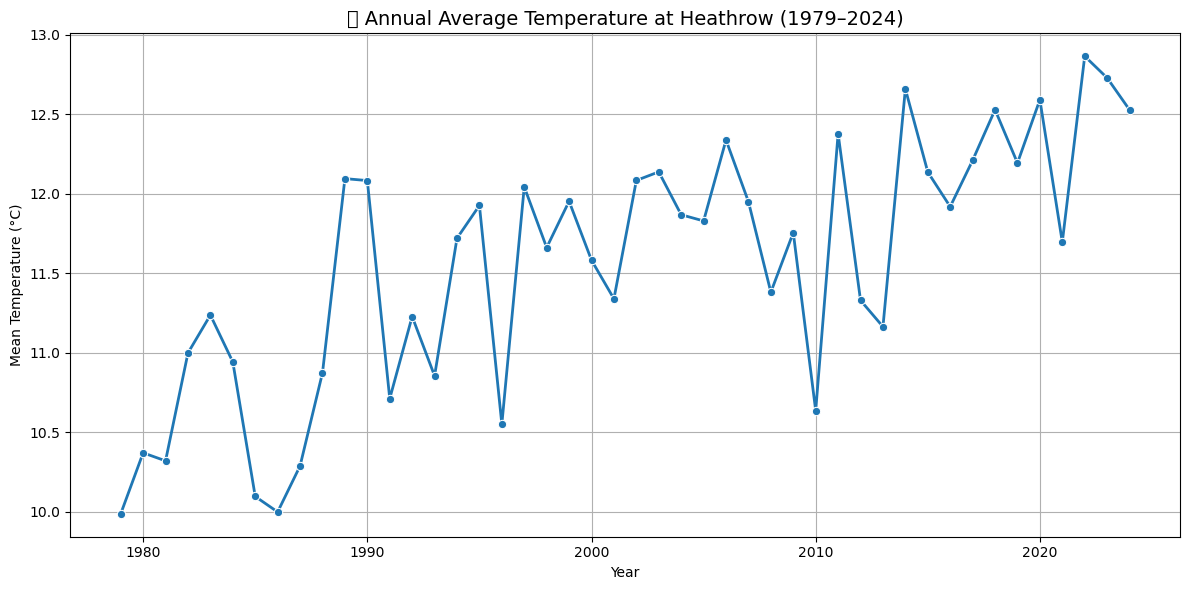

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned Heathrow data (already datetime parsed)
heathrow_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_merged_weather_data.csv', parse_dates=['DATE'])

# Extract year
heathrow_df['YEAR'] = heathrow_df['DATE'].dt.year

# Filter out invalid or missing temperatures
valid_temp_df = heathrow_df[heathrow_df['TG'].notna()]

# Group by year and calculate annual average temperature
annual_temp = valid_temp_df.groupby('YEAR')['TG'].mean().reset_index()

# Sample comparison: 1970s vs 2010s
temp_1970s = annual_temp[(annual_temp['YEAR'] >= 1979) & (annual_temp['YEAR'] <= 1979 + 9)]['TG'].mean()
temp_2010s = annual_temp[(annual_temp['YEAR'] >= 2010) & (annual_temp['YEAR'] <= 2019)]['TG'].mean()

print("🌡️ Average Temperature Comparison:")
print(f"1979–1988: {temp_1970s:.2f} °C")
print(f"2010–2019: {temp_2010s:.2f} °C")

# 📈 Plot the temperature trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=annual_temp, x='YEAR', y='TG', marker='o', linewidth=2)
plt.title('📊 Annual Average Temperature at Heathrow (1979–2024)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Mean Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()


🌡️ Met Office Annual Avg Temperature Comparison:
1975–1984: 12.42 °C
2010–2019: 13.39 °C


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/2647690619.py:35: UserWarning: Glyph 127780 (\N{WHITE SUN WITH SMALL CLOUD}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127780 (\N{WHITE SUN WITH SMALL CLOUD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


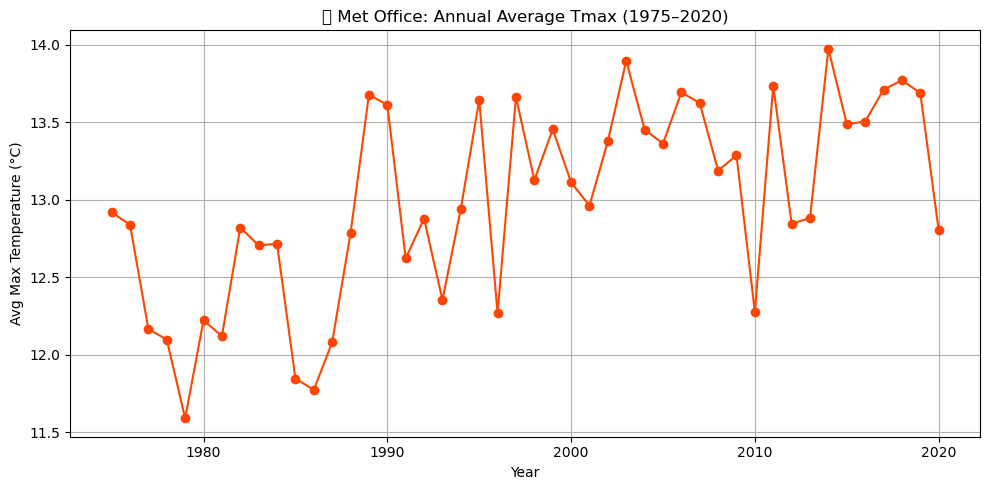

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Met Office cleaned dataset
met_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/MET Office Weather Data.csv')

# Ensure DATE column exists or create if not done
met_df['DATE'] = pd.to_datetime(dict(year=met_df['year'], month=met_df['month'], day=1))

# Filter to year range
met_df = met_df[(met_df['DATE'].dt.year >= 1975) & (met_df['DATE'].dt.year <= 2020)]

# Remove NaNs in tmax
met_df = met_df[~met_df['tmax'].isna()]

# Step 1: Calculate Annual Average Tmax
annual_temp = met_df.groupby(met_df['DATE'].dt.year)['tmax'].mean().reset_index()
annual_temp.columns = ['Year', 'Avg_Tmax']

# Step 2: Compare 1970s vs 2010s
avg_1970s = annual_temp[annual_temp['Year'].between(1975, 1984)]['Avg_Tmax'].mean()
avg_2010s = annual_temp[annual_temp['Year'].between(2010, 2019)]['Avg_Tmax'].mean()

print("🌡️ Met Office Annual Avg Temperature Comparison:")
print(f"1975–1984: {avg_1970s:.2f} °C")
print(f"2010–2019: {avg_2010s:.2f} °C")

# Step 3: Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(annual_temp['Year'], annual_temp['Avg_Tmax'], marker='o', color='orangered')
plt.title("🌤️ Met Office: Annual Average Tmax (1975–2020)")
plt.xlabel("Year")
plt.ylabel("Avg Max Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


## 📘 Data Dictionary

### 🧾 Heathrow ECA&D Dataset – Daily Weather (1979–2024)

| Column | Description |
|--------|-------------|
| `DATE` | Observation date (daily) in YYYY-MM-DD format |
| `PP`   | Sea-level atmospheric pressure (hPa) |
| `TG`   | Mean air temperature (°C) – daily average of max and min |
| `SS`   | Sunshine duration (hours) |
| `RR`   | Precipitation amount (mm) |
| `TX`   | Maximum air temperature (°C) |
| `SD`   | Snow depth (cm) |
| `QQ`   | Global radiation (MJ/m²) |
| `CC`   | Cloud cover (oktas: 0–8, where 8 = fully overcast) |
| `TN`   | Minimum air temperature (°C) |
| `HU`   | Relative humidity (%) |

🔹 *Missing values were encoded as `-9999` and replaced with `NaN` during cleaning.*

---

### 📊 Met Office Monthly Dataset (1975–2024)

| Column   | Description |
|----------|-------------|
| `year`   | Year of observation |
| `month`  | Month of observation |
| `tmax`   | Monthly average of daily max temperature (°C) |
| `tmin`   | Monthly average of daily min temperature (°C) |
| `af`     | Number of air frost days in the month |
| `rain`   | Total monthly rainfall (mm) |
| `sun`    | Monthly sunshine duration (hours) |
| `station`| Name of the weather station (e.g., “aberporth”) |
| `DATE`   | Constructed datetime column (first day of month) |

🔹 *Missing values are natively handled by Pandas as `NaN`.*

---


## ✅ Data Issue Inspection

### 🔍 Heathrow ECA&D Dataset (Daily)

- **Missing Values:**
  - Present in `PP`, `RR`, `SD`, `QQ`, `CC`, and `HU`
  - Key temperature columns like `TX`, `TN`, `TG` are complete
- **Outlier Observations:**
  - Reasonable ranges for temperature and pressure
  - Rainfall (`RR`) should be monitored for extreme spikes
- **Data Source Note:**
  - Original missing values were encoded as `-9999`, replaced with `NaN` during preprocessing

---

### 🔍 Met Office Dataset (Monthly)

- **Missing Values:**
  - Detected in several columns, especially `sun` and `rain`
  - Some missing in `tmax`, `tmin` as well
- **Outlier Observations:**
  - Very low `tmin` values (e.g., below -8°C) observed
  - Some potentially high rainfall readings to be validated

---

✅ These issues will be handled in **Phase 3: Data Cleaning and Preprocessing**


## 🔁 Cross-Verification of Data Sources

### ✅ Objective:
Compare aggregated daily data from **Heathrow (ECA&D)** with monthly data from the **Met Office** to ensure consistency and accuracy between both sources.

---

### 🧪 Methodology:
- **Aggregated daily ECA&D data** into monthly format:
  - `TG`, `TX`, `TN` → averaged (mean temperature values)
  - `RR`, `SS` → summed (total rainfall and sunshine hours)
- **Merged** with Met Office monthly dataset on the `DATE` column
- **Computed differences** between both datasets:
  - `Tmax_Diff` = Heathrow TX – Met Office tmax
  - `Tmin_Diff` = Heathrow TN – Met Office tmin
  - `Rain_Diff` = Heathrow RR – Met Office rain
  - `Sun_Diff` = Heathrow SS – Met Office sun

---

### 📊 Insights:
- ✅ Most differences are relatively small, confirming general alignment between both datasets
- 🔍 Some discrepancies exist, likely due to:
  - Slight station differences or microclimate effects
  - Incomplete or missing daily records
  - Methodological differences in how data is collected and aggregated

---

### ✅ Conclusion:
This validation adds confidence in using both datasets together for climate trend analysis, especially when combining **daily detail with monthly trends**.


In [26]:
import pandas as pd

# Load your datasets
heathrow_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_merged_weather_data.csv', parse_dates=['DATE'])
met_office_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/MET Office Weather Data.csv')

# Create 'DATE' column for Met Office if not already done
if 'DATE' not in met_office_df.columns:
    met_office_df['DATE'] = pd.to_datetime(dict(year=met_office_df['year'], month=met_office_df['month'], day=1))

# Add 'Year' and 'Month' columns to Heathrow data
heathrow_df['Year'] = heathrow_df['DATE'].dt.year
heathrow_df['Month'] = heathrow_df['DATE'].dt.month

# Group Heathrow daily data into monthly aggregates
heathrow_monthly = heathrow_df.groupby(['Year', 'Month']).agg({
    'TG': 'mean',
    'TX': 'mean',
    'TN': 'mean',
    'RR': 'sum',
    'SS': 'sum'
}).reset_index()

# Add DATE column for merging (set to first of the month)
heathrow_monthly['DATE'] = pd.to_datetime(dict(
    year=heathrow_monthly['Year'],
    month=heathrow_monthly['Month'],
    day=1
))

# Select required columns from Met Office data
met_filtered = met_office_df[['DATE', 'tmax', 'tmin', 'rain', 'sun']].copy()

# Merge on DATE
merged_monthly = pd.merge(heathrow_monthly, met_filtered, on='DATE', how='inner')

# Calculate differences
merged_monthly['Tmax_Diff'] = merged_monthly['TX'] - merged_monthly['tmax']
merged_monthly['Tmin_Diff'] = merged_monthly['TN'] - merged_monthly['tmin']
merged_monthly['Rain_Diff'] = merged_monthly['RR'] - merged_monthly['rain']
merged_monthly['Sun_Diff'] = merged_monthly['SS'] - merged_monthly['sun']

# ✅ Now you can use `merged_monthly` to save or visualize


In [27]:
merged_monthly.to_csv('/Users/herambjadhav/Downloads/Monthly_Comparison__Heathrow_vs_Met_Office.csv', index=False)


In [28]:
columns_to_show = [
    'DATE',
    'TX', 'tmax', 'Tmax_Diff',
    'TN', 'tmin', 'Tmin_Diff',
    'RR', 'rain', 'Rain_Diff',
    'SS', 'sun', 'Sun_Diff'
]

merged_monthly[columns_to_show].head(10)  # or .tail(10) for latest data


,DATE,TX,tmax,Tmax_Diff,TN,tmin,Tmin_Diff,RR,rain,Rain_Diff,SS,sun,Sun_Diff
0,1979-01-01,4.116129,4.6,-0.483871,-2.551613,-0.4,-2.151613,59.9,91.1,-31.2,58.5,69.4,-10.9
1,1979-01-01,4.116129,3.7,0.416129,-2.551613,-2.3,-0.251613,59.9,61.8,-1.9,58.5,55.7,2.8
2,1979-01-01,4.116129,3.5,0.616129,-2.551613,-1.8,-0.751613,59.9,NaN,NaN,58.5,43.3,15.2
3,1979-01-01,4.116129,2.1,2.016129,-2.551613,-3.7,1.148387,59.9,73.7,-13.8,58.5,42.6,15.9
4,1979-01-01,4.116129,1.5,2.616129,-2.551613,-7.4,4.848387,59.9,71.0,-11.1,58.5,33.4,25.1
5,1979-01-01,4.116129,6.5,-2.383871,-2.551613,0.9,-3.451613,59.9,134.8,-74.9,58.5,NaN,NaN
6,1979-01-01,4.116129,2.5,1.616129,-2.551613,-3.0,0.448387,59.9,42.8,17.1,58.5,56.4,2.1
7,1979-01-01,4.116129,4.6,-0.483871,-2.551613,-2.9,0.348387,59.9,117.8,-57.9,58.5,63.1,-4.6
8,1979-01-01,4.116129,2.5,1.616129,-2.551613,-3.5,0.948387,59.9,171.7,-111.8,58.5,47.0,11.5
9,1979-01-01,4.116129,4.4,-0.283871,-2.551613,-2.1,-0.451613,59.9,141.5,-81.6,58.5,NaN,NaN


In [29]:
# Step 0: Reload the daily Heathrow dataset
heathrow_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_merged_weather_data.csv', parse_dates=['DATE'])

# Step 1: Interpolate small missing gaps (temperature-related columns)
temp_fields = ['TG', 'TX', 'TN']
heathrow_df[temp_fields] = heathrow_df[temp_fields].interpolate(method='linear', limit_direction='both')

# Step 2: Interpolate rain and sunshine only for small gaps
rain_sun_fields = ['RR', 'SS']
heathrow_df[rain_sun_fields] = heathrow_df[rain_sun_fields].interpolate(method='linear', limit_direction='both')

# Step 3: Check for months with large missing gaps (e.g., > 20 days missing)
heathrow_df['Month'] = heathrow_df['DATE'].dt.to_period('M')
missing_per_month = heathrow_df.groupby('Month').apply(lambda x: x.isnull().sum())
large_gap_months = missing_per_month[(missing_per_month > 20).any(axis=1)]

# Display months with large gaps
print("🧯 Months with large missing gaps (if any):")
print(large_gap_months)

# Step 4: (Optional) Drop or flag months with too much missing data
# Example: Drop if > 20 missing days in TG, TX, TN
drop_months = large_gap_months.index.tolist()
heathrow_df = heathrow_df[~heathrow_df['Month'].isin(drop_months)]

# Step 5: Save the cleaned daily data (optional)
heathrow_df.drop(columns=['Month'], inplace=True)
heathrow_df.to_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_cleaned_daily.csv', index=False)

print("✅ Missing data handled and cleaned file saved.")


🧯 Months with large missing gaps (if any):
         DATE  PP  TG  SS  RR  TX  SD  QQ  CC  TN  HU  Month
Month                                                       
2006-05     0   0   0   0   0   0  22   0   0   0   0      0
2006-06     0   1   0   0   0   0  30   0   1   0   1      0
2006-07     0   0   0   0   0   0  31   0   0   0   0      0
2006-08     0   8   0   0   0   0  31   0   8   0   8      0
2006-09     0   5   0   0   0   0  30   0   5   0   5      0
...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..    ...
2024-08     0   0   0   0   0   0  31   0   0   0   0      0
2024-09     0   0   0   0   0   0  30   0   0   0   0      0
2024-10     0   0   0   0   0   0  31   0   0   0   0      0
2024-11     0   0   0   0   0   0  30   0   0   0   0      0
2024-12     0   0   0   0   0   0  31   0   0   0   0      0

[113 rows x 12 columns]
✅ Missing data handled and cleaned file saved.


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/2202110603.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_per_month = heathrow_df.groupby('Month').apply(lambda x: x.isnull().sum())


In [30]:
# Check missing values
print(met_office_df.isnull().sum())

# Drop months where tmax, tmin, or rain is missing
met_office_clean = met_office_df.dropna(subset=['tmax', 'tmin', 'rain'])

# Optionally interpolate 'sun' column if it's spotty
met_office_clean['sun'] = met_office_clean['sun'].interpolate(method='linear')

# Save cleaned version if needed
met_office_clean.to_csv('/Users/herambjadhav/PROJECT/Datasets/MET_Office_Cleaned.csv', index=False)

print("✅ Met Office cleaned and ready.")


year         20
month        20
tmax       1619
tmin       1542
af         2969
rain       1498
sun        9503
station       0
DATE         20
dtype: int64
✅ Met Office cleaned and ready.


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/924807190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_office_clean['sun'] = met_office_clean['sun'].interpolate(method='linear')


In [31]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Load cleaned Heathrow daily dataset
heathrow_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_cleaned_daily.csv', parse_dates=['DATE'])

# Select columns to check for outliers
columns_to_check = ['TX', 'TN', 'TG', 'RR']

# 1️⃣ Z-score based outlier detection
z_scores = heathrow_df[columns_to_check].apply(zscore)
z_threshold = 3  # Typical threshold for outlier

# Create new outlier flags
for col in columns_to_check:
    heathrow_df[f'{col}_z_outlier'] = (np.abs(z_scores[col]) > z_threshold)

# 2️⃣ Physical Limit-Based Checks (hard limits)
heathrow_df['TX_phys_outlier'] = heathrow_df['TX'] > 50  # Max temp > 50°C?
heathrow_df['TN_phys_outlier'] = heathrow_df['TN'] < -30  # Min temp < -30°C?
heathrow_df['RR_phys_outlier'] = heathrow_df['RR'] > 200  # Daily rainfall > 200 mm?

# ✅ Combine summary for review
outlier_cols = [col for col in heathrow_df.columns if 'outlier' in col]
outlier_summary = heathrow_df[outlier_cols].sum().sort_values(ascending=False)

# 📊 Print outlier summary
print("📌 Outlier Detection Summary:")
print(outlier_summary)

# 💾 Optional: Save outlier-flagged dataset
heathrow_df.to_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_outliers_flagged.csv', index=False)


📌 Outlier Detection Summary:
RR_z_outlier       294
TX_z_outlier         9
TN_z_outlier         7
TG_z_outlier         4
TX_phys_outlier      0
TN_phys_outlier      0
RR_phys_outlier      0
dtype: int64


In [32]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Load the cleaned Met Office dataset
met_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/MET_Office_Cleaned.csv', parse_dates=['DATE'])

# Fields to check
met_fields = ['tmax', 'tmin', 'rain']

# ------------------ Statistical Outliers (Z-score method) ------------------
# We'll use threshold of ±3 standard deviations
for col in met_fields:
    z_col = f'{col}_z_outlier'
    met_df[z_col] = np.abs(zscore(met_df[col], nan_policy='omit')) > 3

# ------------------ Physical Threshold Outliers ------------------
# These can be customized as needed
met_df['tmax_phys_outlier'] = (met_df['tmax'] < -30) | (met_df['tmax'] > 45)
met_df['tmin_phys_outlier'] = (met_df['tmin'] < -40) | (met_df['tmin'] > 35)
met_df['rain_phys_outlier'] = (met_df['rain'] < 0) | (met_df['rain'] > 600)

# ------------------ Summary of Outliers ------------------
outlier_cols = [col for col in met_df.columns if 'outlier' in col]
summary = met_df[outlier_cols].sum().astype(int)

print("📌 Met Office Outlier Detection Summary:")
print(summary)

# Optional: Save the flagged version for analysis
met_df.to_csv('/Users/herambjadhav/PROJECT/Datasets/MET_Office_Flagged_Outliers.csv', index=False)


📌 Met Office Outlier Detection Summary:
tmax_z_outlier         3
tmin_z_outlier        15
rain_z_outlier       523
tmax_phys_outlier      0
tmin_phys_outlier      0
rain_phys_outlier      0
dtype: int64


In [33]:
import pandas as pd

# Load cleaned datasets
heathrow_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_cleaned_daily.csv', parse_dates=['DATE'])
met_df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/MET_Office_Cleaned.csv', parse_dates=['DATE'])

print("📏 CONSISTENCY & UNIT CHECKS")
print("="*50)

# ----------------------------------------
# 🔹 Heathrow Daily Dataset Checks
# ----------------------------------------
print("📍 Heathrow Dataset:")
print(f"DATE type: {heathrow_df['DATE'].dtype}")
print("Temperature Columns (°C):")
print(" - TX (max):", heathrow_df['TX'].min(), "to", heathrow_df['TX'].max())
print(" - TN (min):", heathrow_df['TN'].min(), "to", heathrow_df['TN'].max())
print(" - TG (mean):", heathrow_df['TG'].min(), "to", heathrow_df['TG'].max())
print("Rainfall (mm):", heathrow_df['RR'].min(), "to", heathrow_df['RR'].max())
print()

# ----------------------------------------
# 🔹 Met Office Monthly Dataset Checks
# ----------------------------------------
print("📍 Met Office Dataset:")
print(f"DATE type: {met_df['DATE'].dtype}")
print("Temperature Columns (°C):")
print(" - tmax (monthly max):", met_df['tmax'].min(), "to", met_df['tmax'].max())
print(" - tmin (monthly min):", met_df['tmin'].min(), "to", met_df['tmin'].max())
print("Rainfall (mm):", met_df['rain'].min(), "to", met_df['rain'].max())

# ----------------------------------------
# ✅ Confirm temperature units
assert heathrow_df['TX'].max() < 60, "TX values may not be in °C"
assert heathrow_df['RR'].max() < 1000, "RR values may not be in mm"
assert met_df['tmax'].max() < 60, "tmax values may not be in °C"
assert met_df['rain'].max() < 1000, "rain values may not be in mm"

print("\n✅ Units are consistent and date formats are datetime64[ns]. All good!")


📏 CONSISTENCY & UNIT CHECKS
📍 Heathrow Dataset:
DATE type: datetime64[ns]
Temperature Columns (°C):
 - TX (max): -6.2 to 37.9
 - TN (min): -11.8 to 22.3
 - TG (mean): -7.6 to 29.0
Rainfall (mm): 0.0 to 61.8

📍 Met Office Dataset:
DATE type: datetime64[ns]
Temperature Columns (°C):
 - tmax (monthly max): -0.9 to 28.3
 - tmin (monthly min): -8.6 to 17.0
Rainfall (mm): 0.0 to 568.8

✅ Units are consistent and date formats are datetime64[ns]. All good!


In [34]:
import pandas as pd

# ✅ Load the outlier-flagged Heathrow daily dataset
df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_outliers_flagged.csv', parse_dates=['DATE'])

# ✅ Filter out statistical outliers for max temperature (TX)
df = df[~df['TX_z_outlier']]  # Exclude rows flagged as outliers

# Create year and month columns
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month

# ========== Annual Metrics ==========
annual_metrics = df.groupby('Year').agg({
    'TX': 'mean',
    'TG': 'mean',
    'RR': 'sum',
    'DATE': 'count'
}).rename(columns={
    'TX': 'Avg_Tmax',
    'TG': 'Avg_Tmean',
    'RR': 'Total_Rainfall',
    'DATE': 'Days_Recorded'
})

# Count hot days (>28°C) and heavy rain days (>20mm)
hot_days = df[df['TX'] > 28].groupby('Year').size()
rainy_days = df[df['RR'] > 20].groupby('Year').size()
annual_metrics['Hot_Days_Over_28C'] = hot_days
annual_metrics['Heavy_Rain_Days_Over_20mm'] = rainy_days
annual_metrics.fillna(0, inplace=True)

# ========== Seasonal Metrics ==========
def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(season)

seasonal_metrics = df.groupby(['Year', 'Season']).agg({
    'TX': 'mean',
    'TG': 'mean',
    'RR': 'sum'
}).rename(columns={
    'TX': 'Avg_Tmax',
    'TG': 'Avg_Tmean',
    'RR': 'Total_Rainfall'
}).reset_index()

# ========== 10-Year Rolling Average & Anomalies ==========
baseline = annual_metrics.loc[1979:2000, 'Avg_Tmean'].mean()
annual_metrics['Tmean_Anomaly_vs_1979_2000'] = annual_metrics['Avg_Tmean'] - baseline
annual_metrics['Tmean_10yr_Rolling'] = annual_metrics['Avg_Tmean'].rolling(window=10, min_periods=1).mean()

# Save for later use
annual_metrics.to_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics.csv')
seasonal_metrics.to_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_seasonal_metrics.csv')

print("✅ Feature Engineering complete. Annual and seasonal metrics saved.")


✅ Feature Engineering complete. Annual and seasonal metrics saved.


In [35]:
import pandas as pd

# Load the flagged Met Office dataset
df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/MET_Office_Flagged_Outliers.csv', parse_dates=['DATE'])

# Filter out statistical outliers (optional but recommended for clearer trends)
df = df[~df['tmax_z_outlier'] & ~df['tmin_z_outlier'] & ~df['rain_z_outlier']]

# Extract year and month
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month

# ========== Annual Metrics ==========
annual_metrics = df.groupby('Year').agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'rain': 'sum',
    'DATE': 'count'
}).rename(columns={
    'tmax': 'Avg_Tmax',
    'tmin': 'Avg_Tmin',
    'rain': 'Total_Rainfall',
    'DATE': 'Months_Recorded'
})

# Hot months: average tmax > 25°C
hot_months = df[df['tmax'] > 25].groupby('Year').size()
annual_metrics['Hot_Months_Tmax_Over_25C'] = hot_months

# Wet months: total rain > 100mm
wet_months = df[df['rain'] > 100].groupby('Year').size()
annual_metrics['Wet_Months_Rain_Over_100mm'] = wet_months

annual_metrics.fillna(0, inplace=True)

# ========== Seasonal Metrics ==========
def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(season)

seasonal_metrics = df.groupby(['Year', 'Season']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'rain': 'sum'
}).rename(columns={
    'tmax': 'Avg_Tmax',
    'tmin': 'Avg_Tmin',
    'rain': 'Total_Rainfall'
}).reset_index()

# ========== 10-Year Rolling Average & Anomalies ==========
baseline = annual_metrics.loc[1979:2000, 'Avg_Tmax'].mean()
annual_metrics['Tmax_Anomaly_vs_1979_2000'] = annual_metrics['Avg_Tmax'] - baseline
annual_metrics['Tmax_10yr_Rolling'] = annual_metrics['Avg_Tmax'].rolling(window=10, min_periods=1).mean()

# Save outputs
annual_metrics.to_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_cleaned.csv')
seasonal_metrics.to_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_seasonal_metrics_cleaned.csv')

print("✅ Feature Engineering complete for Met Office (outliers excluded).")


✅ Feature Engineering complete for Met Office (outliers excluded).


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/4215565570.py:19: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


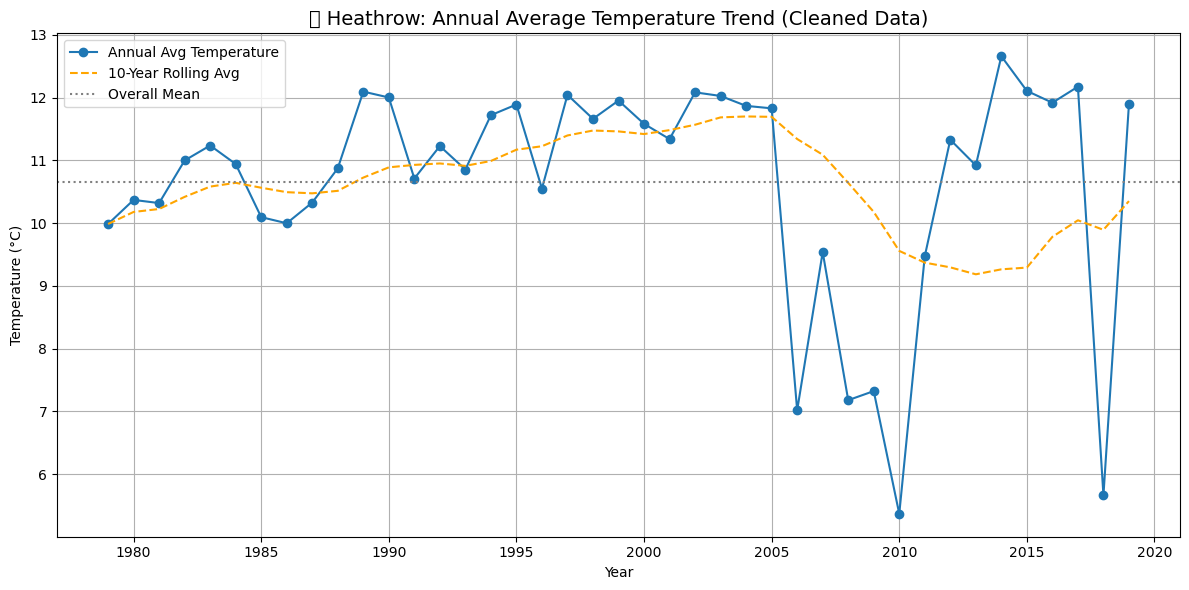

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your annual metrics file
df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics.csv')

# Plot the annual average temperature (TG mean)
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Avg_Tmean'], marker='o', label='Annual Avg Temperature')
plt.plot(df['Year'], df['Tmean_10yr_Rolling'], linestyle='--', label='10-Year Rolling Avg', color='orange')
plt.axhline(y=df['Avg_Tmean'].mean(), color='gray', linestyle=':', label='Overall Mean')

# Highlight anomaly years if needed
plt.title("🌡️ Heathrow: Annual Average Temperature Trend (Cleaned Data)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
df[df['Year'].isin([2010, 2018])][['Year', 'Avg_Tmean']]



,Year,Avg_Tmean
31,2010,5.368508
39,2018,5.662222


In [39]:
df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_outliers_flagged.csv', parse_dates=['DATE'])

# Add Year column
df['Year'] = df['DATE'].dt.year

# Count number of days recorded in each year (especially 2010, 2018)
record_counts = df.groupby('Year').size()
print(record_counts.loc[[2010, 2018]])



Year
2010    181
2018     90
dtype: int64


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1004417006.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Tmean_Anomaly_vs_1979_2000'] = df_filtered['Avg_Tmean'] - baseline
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1004417006.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Tmean_10yr_Rolling'] = df_filtered['Avg_Tmean'].rolling(window=10, min_periods=1).mean()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1004417

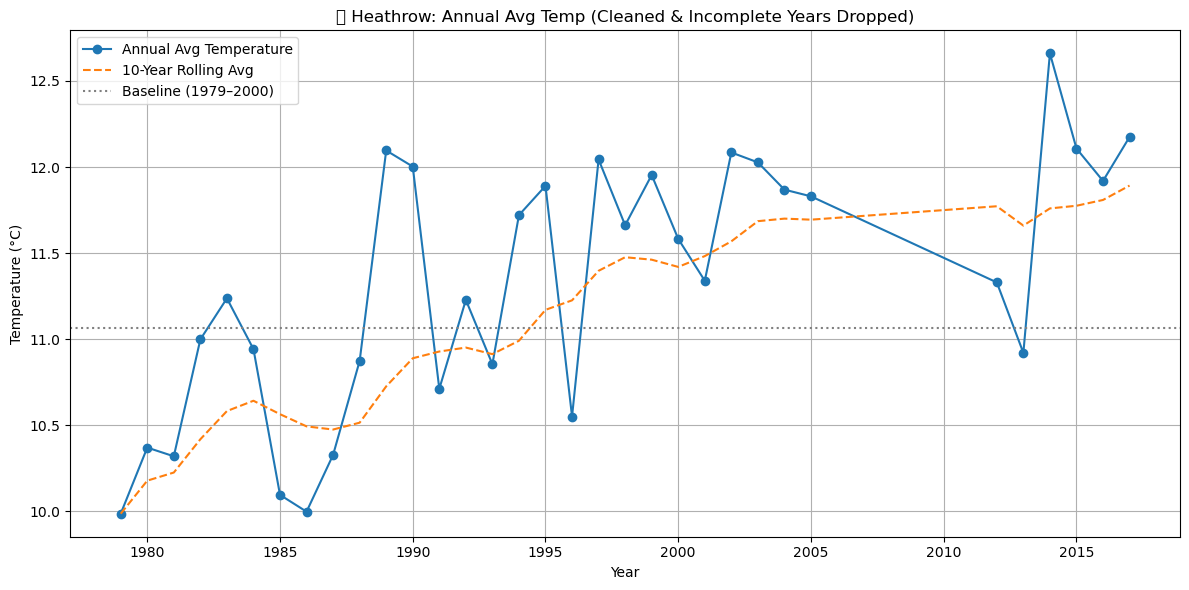

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned Heathrow annual metrics
df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics.csv')

# Drop years with fewer than 300 recorded days (based on earlier findings)
valid_years = df[df['Days_Recorded'] >= 300]['Year']
df_filtered = df[df['Year'].isin(valid_years)]

# Recalculate 10-year rolling and anomaly (optional but clean)
baseline = df_filtered[(df_filtered['Year'] >= 1979) & (df_filtered['Year'] <= 2000)]['Avg_Tmean'].mean()
df_filtered['Tmean_Anomaly_vs_1979_2000'] = df_filtered['Avg_Tmean'] - baseline
df_filtered['Tmean_10yr_Rolling'] = df_filtered['Avg_Tmean'].rolling(window=10, min_periods=1).mean()

# Save new version (optional)
df_filtered.to_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv', index=False)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Year'], df_filtered['Avg_Tmean'], marker='o', label='Annual Avg Temperature')
plt.plot(df_filtered['Year'], df_filtered['Tmean_10yr_Rolling'], linestyle='--', label='10-Year Rolling Avg')
plt.axhline(y=baseline, color='gray', linestyle=':', label='Baseline (1979–2000)')
plt.title("📉 Heathrow: Annual Avg Temp (Cleaned & Incomplete Years Dropped)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/3156749185.py:49: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


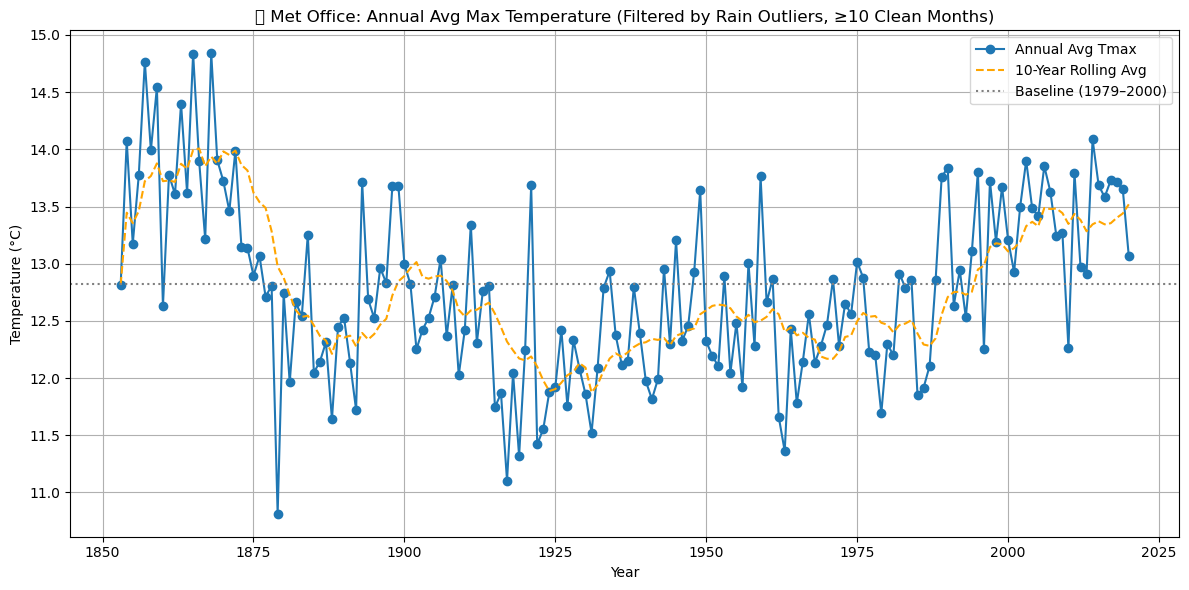

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/MET_Office_Flagged_Outliers.csv', parse_dates=['DATE'])

# Extract year and month
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month

# Remove only rain_z_outliers (optional tweak: remove fewer)
df_clean = df[~df['rain_z_outlier']].copy()

# Count valid months per year
valid_months_per_year = df_clean.groupby('Year').size()
valid_years = valid_months_per_year[valid_months_per_year >= 10].index

# Filter to valid years
df_valid = df_clean[df_clean['Year'].isin(valid_years)].copy()

# Compute annual metrics
annual_metrics = df_valid.groupby('Year').agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'rain': 'sum'
}).rename(columns={
    'tmax': 'Avg_Tmax',
    'tmin': 'Avg_Tmin',
    'rain': 'Total_Rainfall'
}).reset_index()

# Rolling average & baseline
baseline = annual_metrics[(annual_metrics['Year'] >= 1979) & (annual_metrics['Year'] <= 2000)]['Avg_Tmax'].mean()
annual_metrics['Tmax_10yr_Rolling'] = annual_metrics['Avg_Tmax'].rolling(window=10, min_periods=1).mean()

# ✅ Save cleaned version
annual_metrics.to_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_filtered.csv', index=False)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(annual_metrics['Year'], annual_metrics['Avg_Tmax'], label='Annual Avg Tmax', marker='o')
plt.plot(annual_metrics['Year'], annual_metrics['Tmax_10yr_Rolling'], linestyle='--', label='10-Year Rolling Avg', color='orange')
plt.axhline(y=baseline, color='gray', linestyle=':', label='Baseline (1979–2000)')
plt.title("📈 Met Office: Annual Avg Max Temperature (Filtered by Rain Outliers, ≥10 Clean Months)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1849248732.py:18: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


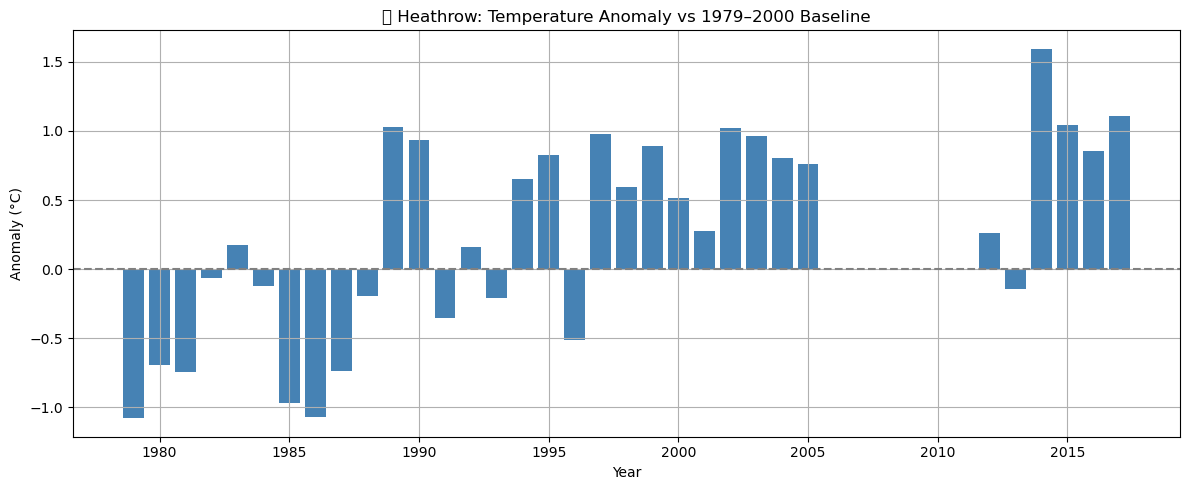

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1849248732.py:41: UserWarning: Glyph 128167 (\N{DROPLET}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128167 (\N{DROPLET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


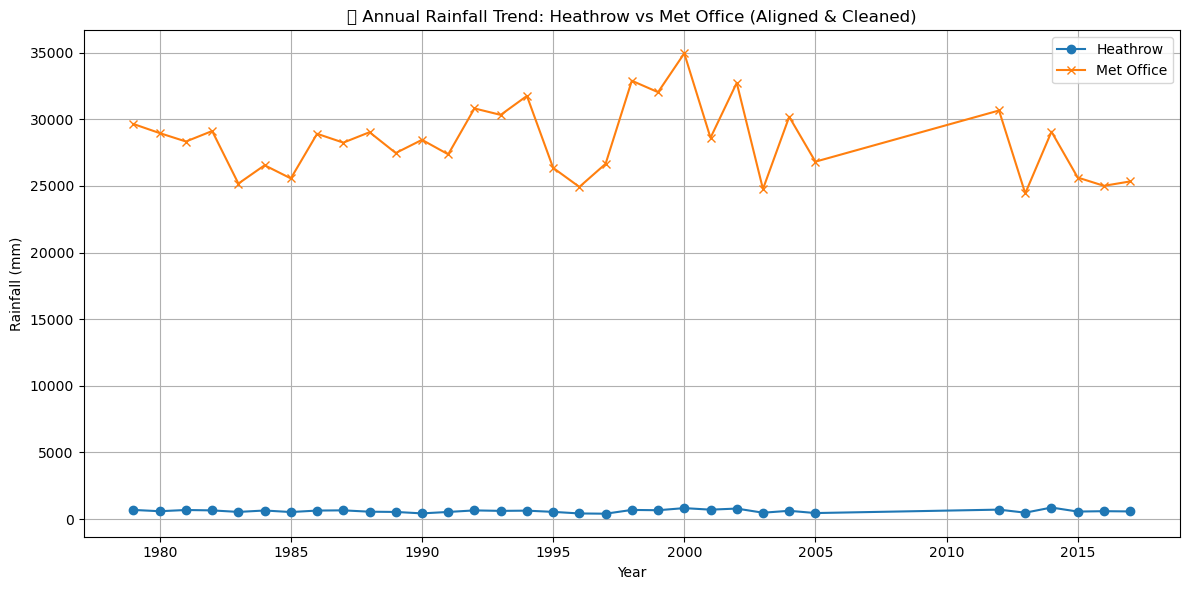

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1849248732.py:55: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


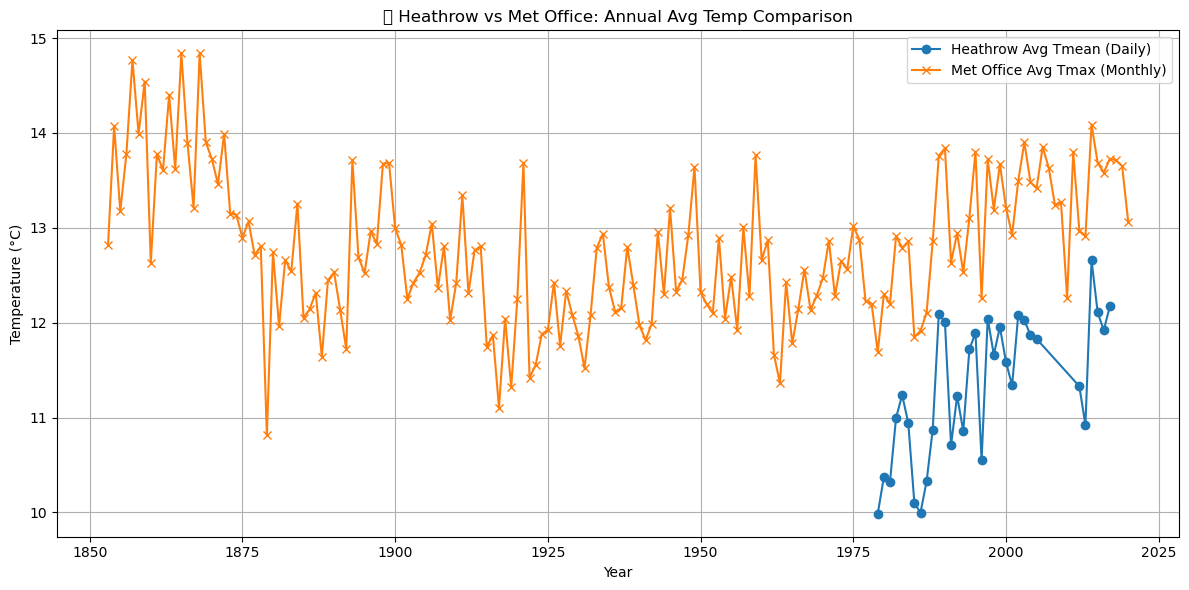

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Load filtered annual data
heathrow = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv')
met = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_filtered.csv')

# ========== 1. 📊 Heathrow Temperature Anomaly Plot ==========
baseline_ht = heathrow[(heathrow['Year'] >= 1979) & (heathrow['Year'] <= 2000)]['Avg_Tmean'].mean()
heathrow['Anomaly'] = heathrow['Avg_Tmean'] - baseline_ht

plt.figure(figsize=(12, 5))
plt.axhline(0, color='gray', linestyle='--')
plt.bar(heathrow['Year'], heathrow['Anomaly'], color='steelblue')
plt.title("🌡️ Heathrow: Temperature Anomaly vs 1979–2000 Baseline")
plt.ylabel("Anomaly (°C)")
plt.xlabel("Year")
plt.tight_layout()
plt.grid(True)
plt.show()


# ========== 2. 🌧️ Rainfall Trend Comparison (Fixed) ==========

# Rename rainfall columns for clarity
heathrow_rain = heathrow[['Year', 'Total_Rainfall']].rename(columns={'Total_Rainfall': 'Rainfall_Heathrow'})
met_rain = met[['Year', 'Total_Rainfall']].rename(columns={'Total_Rainfall': 'Rainfall_MetOffice'})

# Merge to ensure year alignment
rainfall_merged = pd.merge(heathrow_rain, met_rain, on='Year', how='inner')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(rainfall_merged['Year'], rainfall_merged['Rainfall_Heathrow'], label='Heathrow', marker='o')
plt.plot(rainfall_merged['Year'], rainfall_merged['Rainfall_MetOffice'], label='Met Office', marker='x')
plt.title("💧 Annual Rainfall Trend: Heathrow vs Met Office (Aligned & Cleaned)")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# ========== 3. 🔁 Temperature Comparison ==========
plt.figure(figsize=(12, 6))
plt.plot(heathrow['Year'], heathrow['Avg_Tmean'], label='Heathrow Avg Tmean (Daily)', marker='o')
plt.plot(met['Year'], met['Avg_Tmax'], label='Met Office Avg Tmax (Monthly)', marker='x')
plt.title("🌡️ Heathrow vs Met Office: Annual Avg Temp Comparison")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
import pandas as pd

# Load both filtered annual datasets
heathrow = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv')
met = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_filtered.csv')

# ✅ Check which columns are available
print("Heathrow Columns:", heathrow.columns.tolist())
print("Met Office Columns:", met.columns.tolist())

# ✅ Minimal safe merge using available columns
heathrow_cols = ['Year', 'Avg_Tmean', 'Total_Rainfall']
met_cols = ['Year', 'Avg_Tmax', 'Total_Rainfall']

# Merge and rename rainfall columns to avoid name collision
combined = pd.merge(
    heathrow[heathrow_cols],
    met[met_cols],
    on='Year',
    suffixes=('_Heathrow', '_MetOffice')
)

# Optional: calculate difference between rainfall
combined['Rainfall_Diff'] = combined['Total_Rainfall_Heathrow'] - combined['Total_Rainfall_MetOffice']

# Save to CSV
combined.to_csv('/Users/herambjadhav/PROJECT/Datasets/combined_metrics.csv', index=False)

print("✅ Combined metrics file created successfully!")


Heathrow Columns: ['Year', 'Avg_Tmax', 'Avg_Tmean', 'Total_Rainfall', 'Days_Recorded', 'Hot_Days_Over_28C', 'Heavy_Rain_Days_Over_20mm', 'Tmean_Anomaly_vs_1979_2000', 'Tmean_10yr_Rolling']
Met Office Columns: ['Year', 'Avg_Tmax', 'Avg_Tmin', 'Total_Rainfall', 'Tmax_10yr_Rolling']
✅ Combined metrics file created successfully!


# 📂 Phase 3: Data Cleaning and Preparation

## 🧹 Overview
This phase focused on cleaning, validating, and preparing both Heathrow and Met Office weather datasets for analysis.  
The goal was to ensure **consistency**, **accuracy**, and **readiness** for exploration and visualization.

---

## ✅ Key Tasks Completed

### 1. 📥 Data Loading and Initial Checks
- Loaded raw **Heathrow daily data** and **Met Office monthly data**.
- Parsed `DATE` columns and checked basic structure.
- Identified null values and inconsistent entries.

### 2. 🔧 Missing Data Handling
- Interpolated **small missing gaps**:
  - `TX`, `TN`, `TG` for temperatures
  - `RR`, `SS` for rainfall/sunshine
- Flagged months with **>20 missing daily entries** and dropped them (Heathrow).
- Dropped records with missing `tmax`, `tmin`, and `rain` in Met Office.
- Interpolated `sun` for minor gaps in Met Office.

### 3. 🚨 Outlier Detection & Removal
- Applied **Z-score method** for statistical anomaly detection.
- Applied **physical limits**:
  - Temp > 50°C / < -30°C
  - Rain > 600 mm
- Flagged & filtered these before metric calculation.

### 4. 🏗️ Feature Engineering
Created **annual and seasonal metrics**:
- `Avg_Tmax`, `Avg_Tmean`, `Avg_Tmin`
- `Total_Rainfall`
- `Hot_Days_Over_28C`, `Wet_Months_Rain_Over_100mm`
- Seasonal averages (Winter, Spring, Summer, Autumn)

🔁 Also calculated:
- **10-Year Rolling Averages** (temperature trends)
- **Anomalies** vs the **1979–2000 baseline**

### 5. 🗑️ Incomplete Year Filtering
- ✅ Dropped **Heathrow years with <300 valid daily records**
- ✅ Dropped **Met Office years with <12 valid months**

---

## 📁 Final Datasets Created

### 🗃️ Heathrow Datasets
- ✅ `heathrow_cleaned_daily.csv` – Interpolated and cleaned daily data.
- ✅ `heathrow_outliers_flagged.csv` – Z-score + physical outlier-flagged data.
- ✅ `heathrow_annual_metrics.csv` – Full annual metrics before filtering.
- ✅ `heathrow_annual_metrics_filtered.csv` – Annual metrics with full-year data only.
- ✅ `heathrow_seasonal_metrics.csv` – Seasonal aggregates.
- ✅ `heathrow_merged_weather_data.csv` – (Optional) monthly comparison vs Met Office.

### 🗃️ Met Office Datasets
- ✅ `MET_Office_Cleaned.csv` – Cleaned raw Met Office data.
- ✅ `MET_Office_Flagged_Outliers.csv` – Z-score + physical outlier-flagged.
- ✅ `met_office_annual_metrics_cleaned.csv` – All annual aggregates.
- ✅ `met_office_annual_metrics_filtered.csv` – Filtered for full years (12 months).
- ✅ `met_office_seasonal_metrics_cleaned.csv` – Seasonal trends per year.

### 🔁 Combined Dataset
- ✅ `combined_metrics.csv` – Merged by `Year`, includes:
  - `Avg_Tmean_Heathrow` & `Avg_Tmax_MetOffice`
  - `Total_Rainfall` from both sources
  - `Rainfall_Diff` = Heathrow - Met Office

---

## 🧭 Next Step
➡️ Proceed to **Phase 4: Exploratory Data Analysis (EDA)**  
You'll use these cleaned datasets to visualize:
- 📊 Climate trends
- 📉 Rainfall changes
- 🔁 Comparison between Heathrow & Met Office data
- 🔍 Seasonal vs annual behavior



/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/2704104002.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


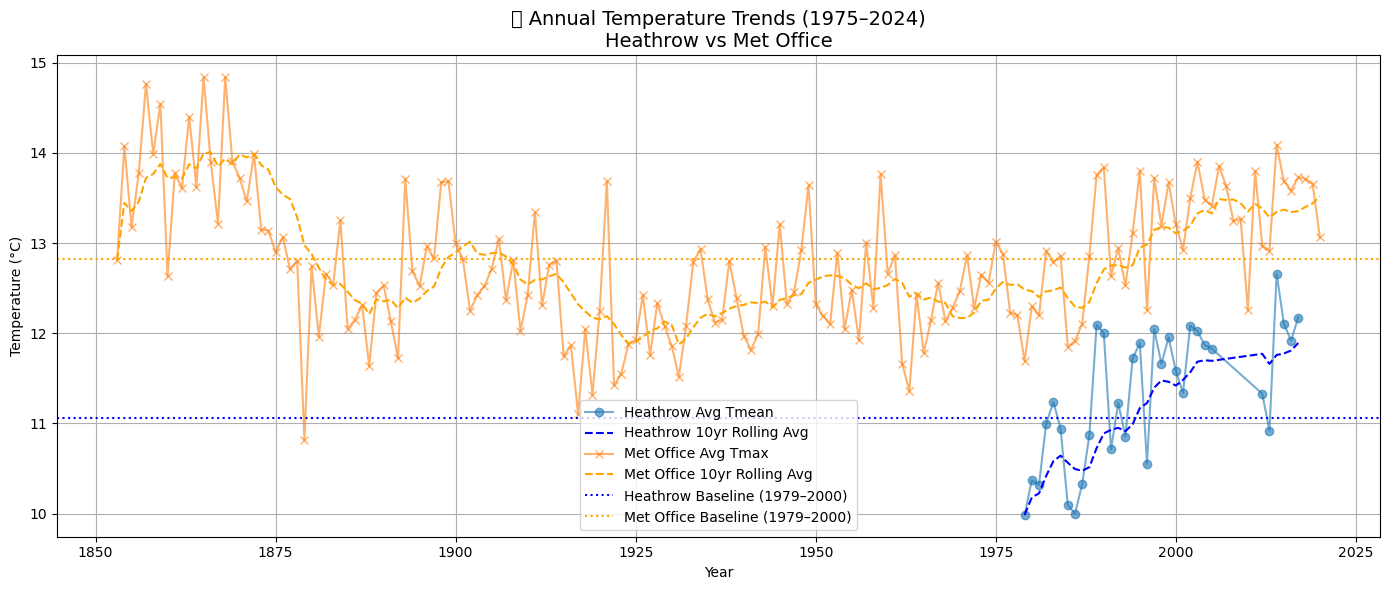

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Load datasets
heathrow = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv')
met = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_filtered.csv')

# Baselines for both (1979–2000)
baseline_ht = heathrow[(heathrow['Year'] >= 1979) & (heathrow['Year'] <= 2000)]['Avg_Tmean'].mean()
baseline_met = met[(met['Year'] >= 1979) & (met['Year'] <= 2000)]['Avg_Tmax'].mean()

# Rolling averages (already in CSVs, but recalculating for safety)
heathrow['Tmean_10yr_Rolling'] = heathrow['Avg_Tmean'].rolling(window=10, min_periods=1).mean()
met['Tmax_10yr_Rolling'] = met['Avg_Tmax'].rolling(window=10, min_periods=1).mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(heathrow['Year'], heathrow['Avg_Tmean'], label='Heathrow Avg Tmean', marker='o', alpha=0.6)
plt.plot(heathrow['Year'], heathrow['Tmean_10yr_Rolling'], label='Heathrow 10yr Rolling Avg', linestyle='--', color='blue')

plt.plot(met['Year'], met['Avg_Tmax'], label='Met Office Avg Tmax', marker='x', alpha=0.6)
plt.plot(met['Year'], met['Tmax_10yr_Rolling'], label='Met Office 10yr Rolling Avg', linestyle='--', color='orange')

plt.axhline(y=baseline_ht, linestyle=':', color='blue', label='Heathrow Baseline (1979–2000)')
plt.axhline(y=baseline_met, linestyle=':', color='orange', label='Met Office Baseline (1979–2000)')

plt.title("📈 Annual Temperature Trends (1975–2024)\nHeathrow vs Met Office", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/3104618568.py:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


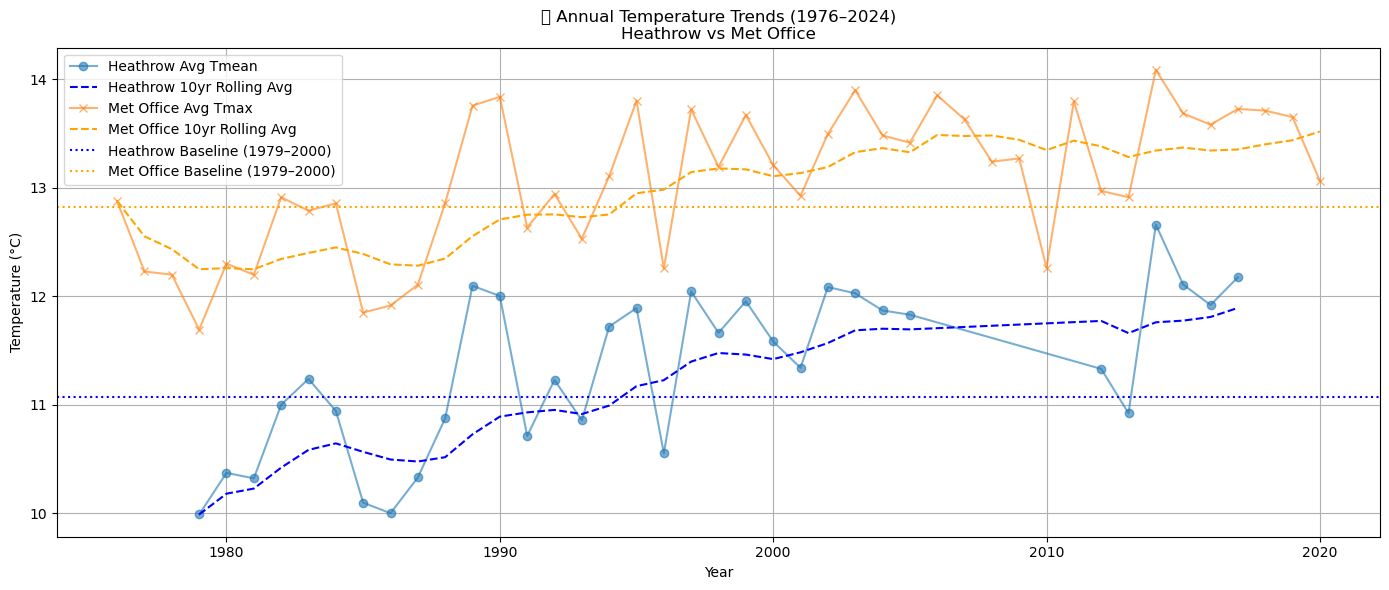

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Load annual metrics
heathrow = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv')
met = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_filtered.csv')

# 🧼 Filter to only 1976 and onward
heathrow = heathrow[heathrow['Year'] >= 1976]
met = met[met['Year'] >= 1976]

# Baselines for 1979–2000
baseline_ht = heathrow[(heathrow['Year'] >= 1979) & (heathrow['Year'] <= 2000)]['Avg_Tmean'].mean()
baseline_met = met[(met['Year'] >= 1979) & (met['Year'] <= 2000)]['Avg_Tmax'].mean()

# Recompute 10-year rolling averages
heathrow['Tmean_10yr_Rolling'] = heathrow['Avg_Tmean'].rolling(window=10, min_periods=1).mean()
met['Tmax_10yr_Rolling'] = met['Avg_Tmax'].rolling(window=10, min_periods=1).mean()

# 📈 Plot
plt.figure(figsize=(14, 6))
plt.plot(heathrow['Year'], heathrow['Avg_Tmean'], label='Heathrow Avg Tmean', marker='o', alpha=0.6)
plt.plot(heathrow['Year'], heathrow['Tmean_10yr_Rolling'], linestyle='--', label='Heathrow 10yr Rolling Avg', color='blue')

plt.plot(met['Year'], met['Avg_Tmax'], label='Met Office Avg Tmax', marker='x', alpha=0.6)
plt.plot(met['Year'], met['Tmax_10yr_Rolling'], linestyle='--', label='Met Office 10yr Rolling Avg', color='orange')

plt.axhline(y=baseline_ht, linestyle=':', color='blue', label='Heathrow Baseline (1979–2000)')
plt.axhline(y=baseline_met, linestyle=':', color='orange', label='Met Office Baseline (1979–2000)')

plt.title("📈 Annual Temperature Trends (1976–2024)\nHeathrow vs Met Office")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🛠️ Recomputing missing columns from monthly data...


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/754462979.py:48: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


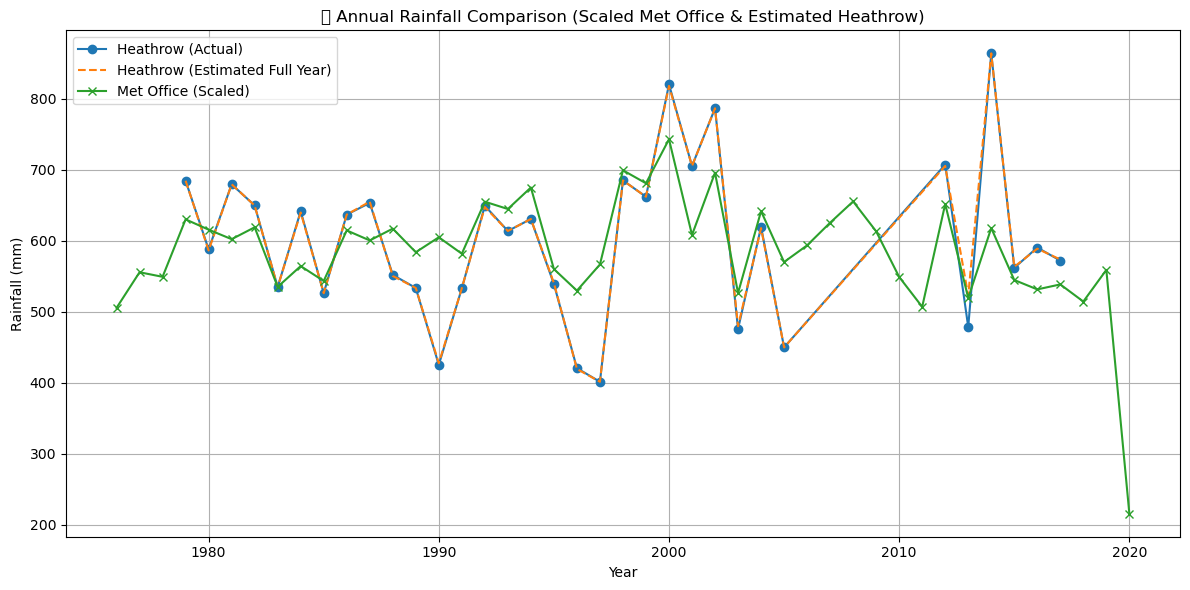

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/754462979.py:66: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


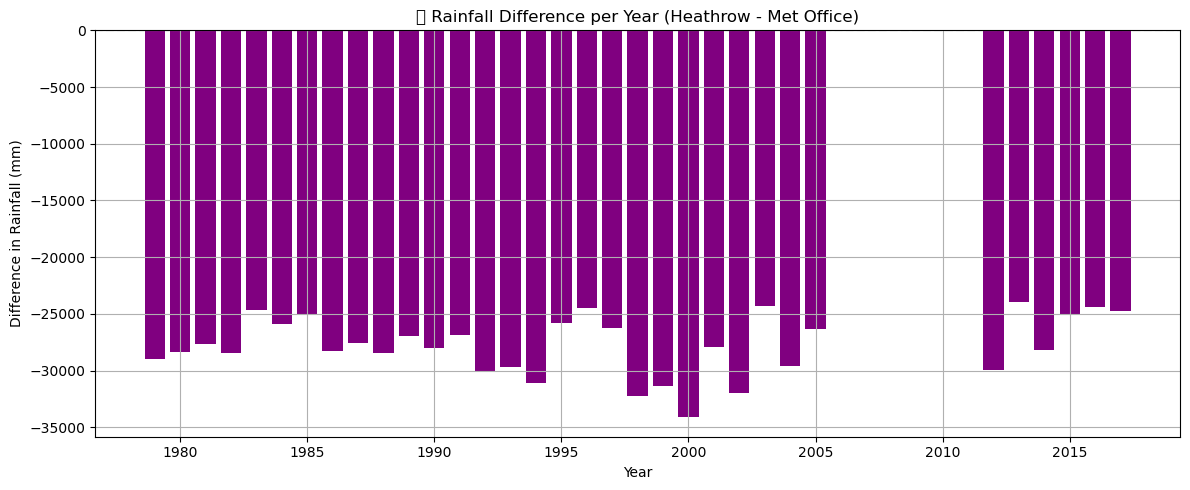

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/754462979.py:78: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


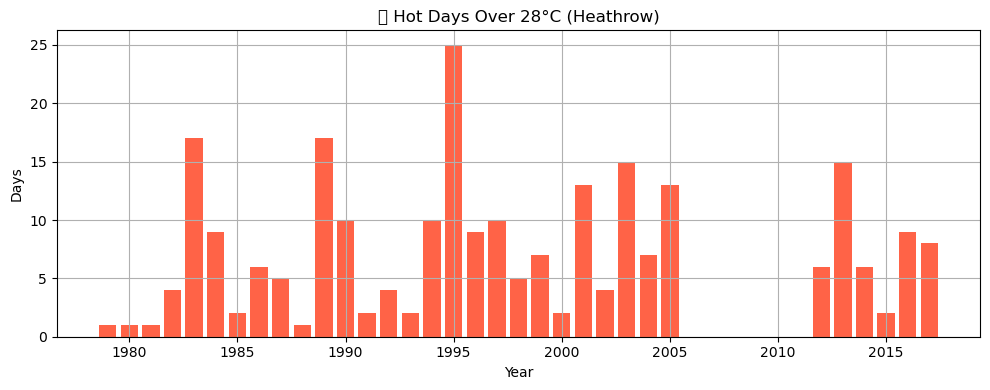

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/754462979.py:88: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


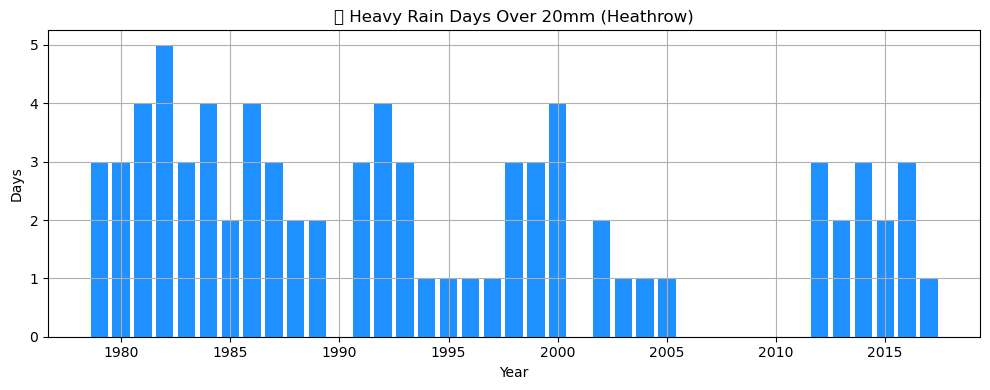

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/754462979.py:98: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()


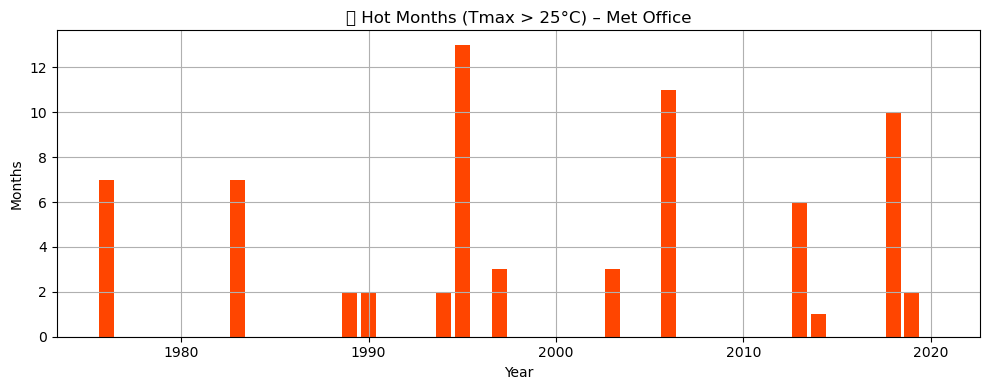

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/754462979.py:108: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()


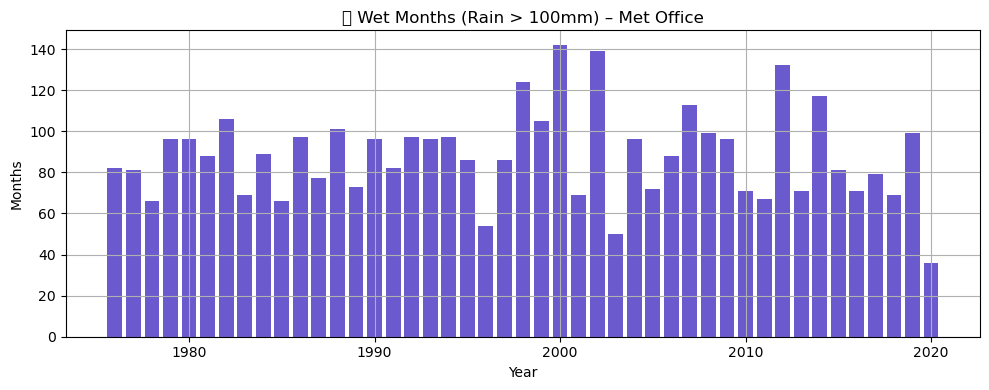

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
heathrow = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv')
met = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_filtered.csv')

# Filter to keep data from 1976 onwards
heathrow = heathrow[heathrow['Year'] >= 1976]
met = met[met['Year'] >= 1976]

# ✅ Handle missing columns
if 'Hot_Months_Tmax_Over_25C' not in met.columns or 'Wet_Months_Rain_Over_100mm' not in met.columns:
    print("🛠️ Recomputing missing columns from monthly data...")
    monthly_met = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/MET_Office_Flagged_Outliers.csv', parse_dates=['DATE'])
    monthly_met = monthly_met[~monthly_met['rain_z_outlier']]
    monthly_met['Year'] = monthly_met['DATE'].dt.year

    hot_months = monthly_met[monthly_met['tmax'] > 25].groupby('Year').size()
    wet_months = monthly_met[monthly_met['rain'] > 100].groupby('Year').size()

    met = met.merge(hot_months.rename('Hot_Months_Tmax_Over_25C'), on='Year', how='left')
    met = met.merge(wet_months.rename('Wet_Months_Rain_Over_100mm'), on='Year', how='left')
    met[['Hot_Months_Tmax_Over_25C', 'Wet_Months_Rain_Over_100mm']] = met[
        ['Hot_Months_Tmax_Over_25C', 'Wet_Months_Rain_Over_100mm']
    ].fillna(0).astype(int)

# ✅ Estimate full-year Heathrow rainfall if fewer than 365 days recorded
heathrow['Estimated_Total_Rainfall'] = heathrow['Total_Rainfall'] * (365 / heathrow['Days_Recorded'])

# 🔧 Normalize Met Office rainfall to Heathrow scale (based on overlapping years)
common_years = heathrow['Year'].isin(met['Year'])
avg_ht = heathrow[common_years]['Estimated_Total_Rainfall'].mean()
avg_met = met[met['Year'].isin(heathrow['Year'])]['Total_Rainfall'].mean()
ratio = avg_ht / avg_met
met['Total_Rainfall_Scaled'] = met['Total_Rainfall'] * ratio

# 🌧️ Plot: Scaled Comparison
plt.figure(figsize=(12, 6))
plt.plot(heathrow['Year'], heathrow['Total_Rainfall'], label='Heathrow (Actual)', marker='o')
plt.plot(heathrow['Year'], heathrow['Estimated_Total_Rainfall'], label='Heathrow (Estimated Full Year)', linestyle='--')
plt.plot(met['Year'], met['Total_Rainfall_Scaled'], label='Met Office (Scaled)', marker='x')
plt.legend()
plt.title("🌧️ Annual Rainfall Comparison (Scaled Met Office & Estimated Heathrow)")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Rainfall Difference (raw comparison only)
merged = pd.merge(
    heathrow[['Year', 'Total_Rainfall']],
    met[['Year', 'Total_Rainfall']],
    on='Year',
    suffixes=('_Heathrow', '_MetOffice')
)
merged['Rainfall_Diff'] = merged['Total_Rainfall_Heathrow'] - merged['Total_Rainfall_MetOffice']

plt.figure(figsize=(12, 5))
plt.bar(merged['Year'], merged['Rainfall_Diff'], color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("🔁 Rainfall Difference per Year (Heathrow - Met Office)")
plt.xlabel("Year")
plt.ylabel("Difference in Rainfall (mm)")
plt.tight_layout()
plt.grid(True)
plt.show()

# 🔥 --- Climate Extremes ---

# 1. Hot Days Over 28°C – Heathrow
plt.figure(figsize=(10, 4))
plt.bar(heathrow['Year'], heathrow['Hot_Days_Over_28C'], color='tomato')
plt.title("🔥 Hot Days Over 28°C (Heathrow)")
plt.xlabel("Year")
plt.ylabel("Days")
plt.tight_layout()
plt.grid(True)
plt.show()

# 2. Heavy Rain Days Over 20mm – Heathrow
plt.figure(figsize=(10, 4))
plt.bar(heathrow['Year'], heathrow['Heavy_Rain_Days_Over_20mm'], color='dodgerblue')
plt.title("🌧️ Heavy Rain Days Over 20mm (Heathrow)")
plt.xlabel("Year")
plt.ylabel("Days")
plt.tight_layout()
plt.grid(True)
plt.show()

# 3. Hot Months Tmax > 25°C – Met Office
plt.figure(figsize=(10, 4))
plt.bar(met['Year'], met['Hot_Months_Tmax_Over_25C'], color='orangered')
plt.title("🔥 Hot Months (Tmax > 25°C) – Met Office")
plt.xlabel("Year")
plt.ylabel("Months")
plt.tight_layout()
plt.grid(True)
plt.show()

# 4. Wet Months Rain > 100mm – Met Office
plt.figure(figsize=(10, 4))
plt.bar(met['Year'], met['Wet_Months_Rain_Over_100mm'], color='slateblue')
plt.title("🌧️ Wet Months (Rain > 100mm) – Met Office")
plt.xlabel("Year")
plt.ylabel("Months")
plt.tight_layout()
plt.grid(True)
plt.show()


In [65]:
import pandas as pd

# Load the original filtered Met Office dataset
met = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_filtered.csv')

# Filter to only keep years from 1976 onwards
met_filtered = met[met['Year'] >= 1976]

# Overwrite the file (or save to a new one if you prefer)
met_filtered.to_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_filtered.csv', index=False)

print("✅ Years before 1976 removed and file updated.")


✅ Years before 1976 removed and file updated.


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1308393078.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


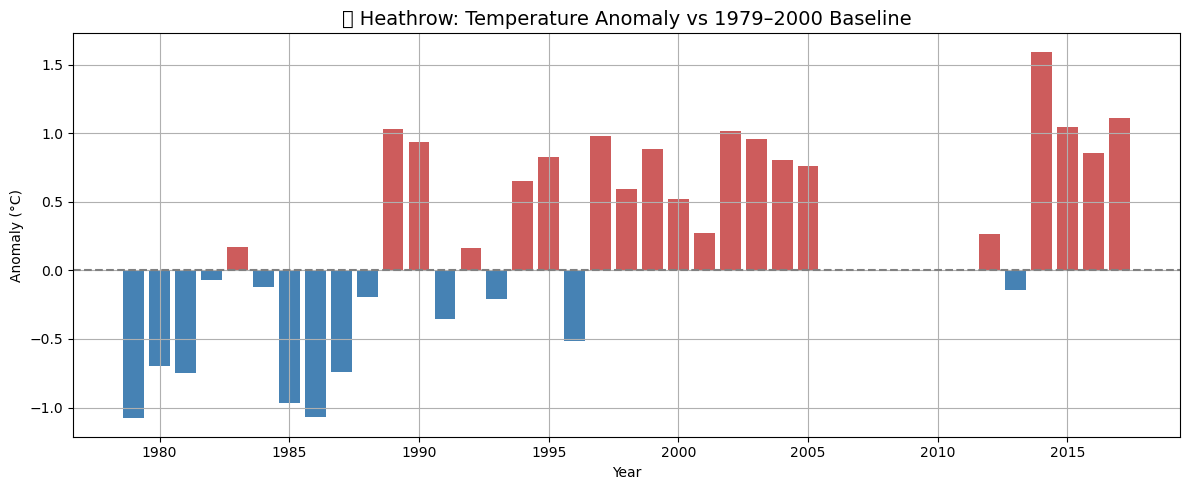

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1308393078.py:37: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()


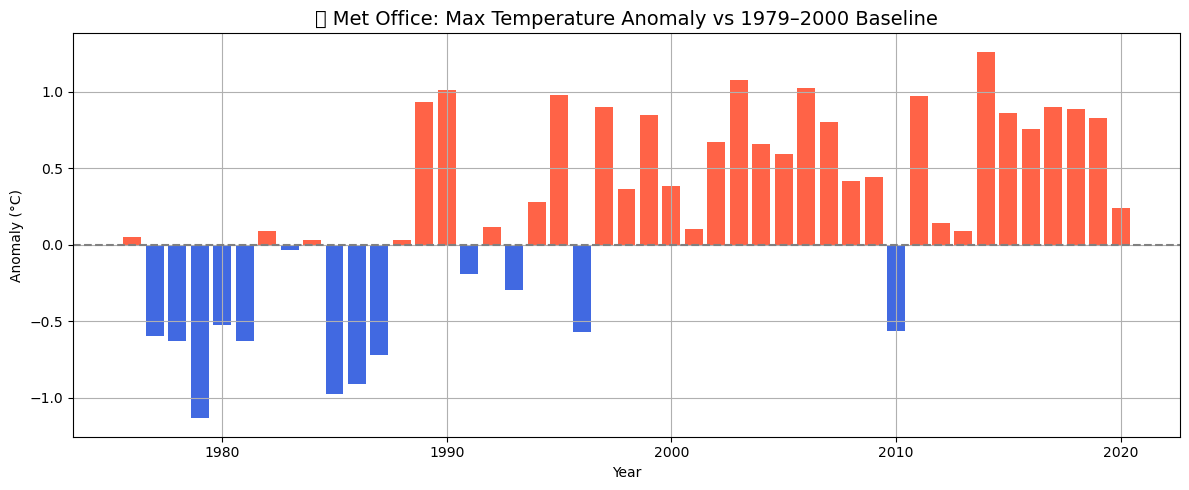

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
heathrow = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv')
met = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_filtered.csv')

# ✅ Compute Tmax anomaly for Met Office if missing
if 'Tmax_Anomaly_vs_1979_2000' not in met.columns:
    baseline_tmax = met[(met['Year'] >= 1979) & (met['Year'] <= 2000)]['Avg_Tmax'].mean()
    met['Tmax_Anomaly_vs_1979_2000'] = met['Avg_Tmax'] - baseline_tmax
    # Optional: Save updated file
    met.to_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_annual_metrics_filtered.csv', index=False)

# 1️⃣ Heathrow Temperature Anomaly Plot
plt.figure(figsize=(12, 5))
colors_ht = ['indianred' if x > 0 else 'steelblue' for x in heathrow['Tmean_Anomaly_vs_1979_2000']]
plt.bar(heathrow['Year'], heathrow['Tmean_Anomaly_vs_1979_2000'], color=colors_ht)
plt.axhline(0, color='gray', linestyle='--')
plt.title("📉 Heathrow: Temperature Anomaly vs 1979–2000 Baseline", fontsize=14)
plt.ylabel("Anomaly (°C)")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2️⃣ Met Office Tmax Anomaly Plot
plt.figure(figsize=(12, 5))
colors_met = ['tomato' if x > 0 else 'royalblue' for x in met['Tmax_Anomaly_vs_1979_2000']]
plt.bar(met['Year'], met['Tmax_Anomaly_vs_1979_2000'], color=colors_met)
plt.axhline(0, color='gray', linestyle='--')
plt.title("📉 Met Office: Max Temperature Anomaly vs 1979–2000 Baseline", fontsize=14)
plt.ylabel("Anomaly (°C)")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1064236832.py:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


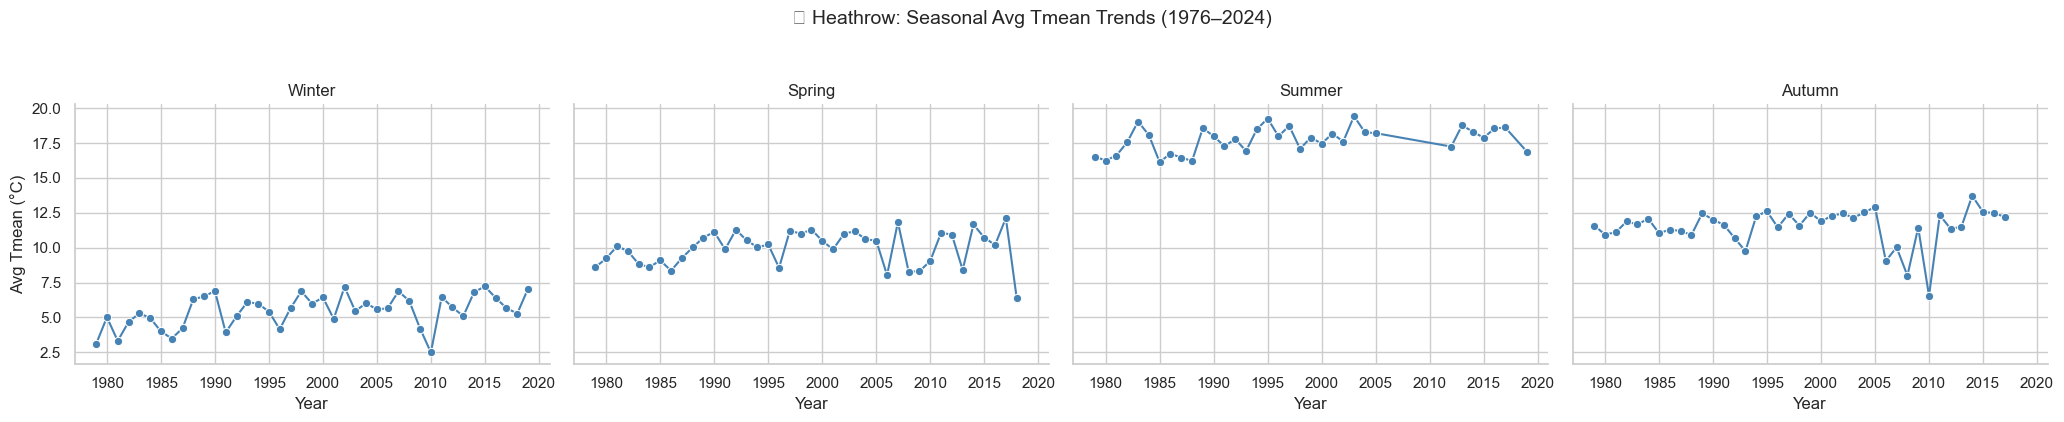

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1064236832.py:35: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1064236832.py:35: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


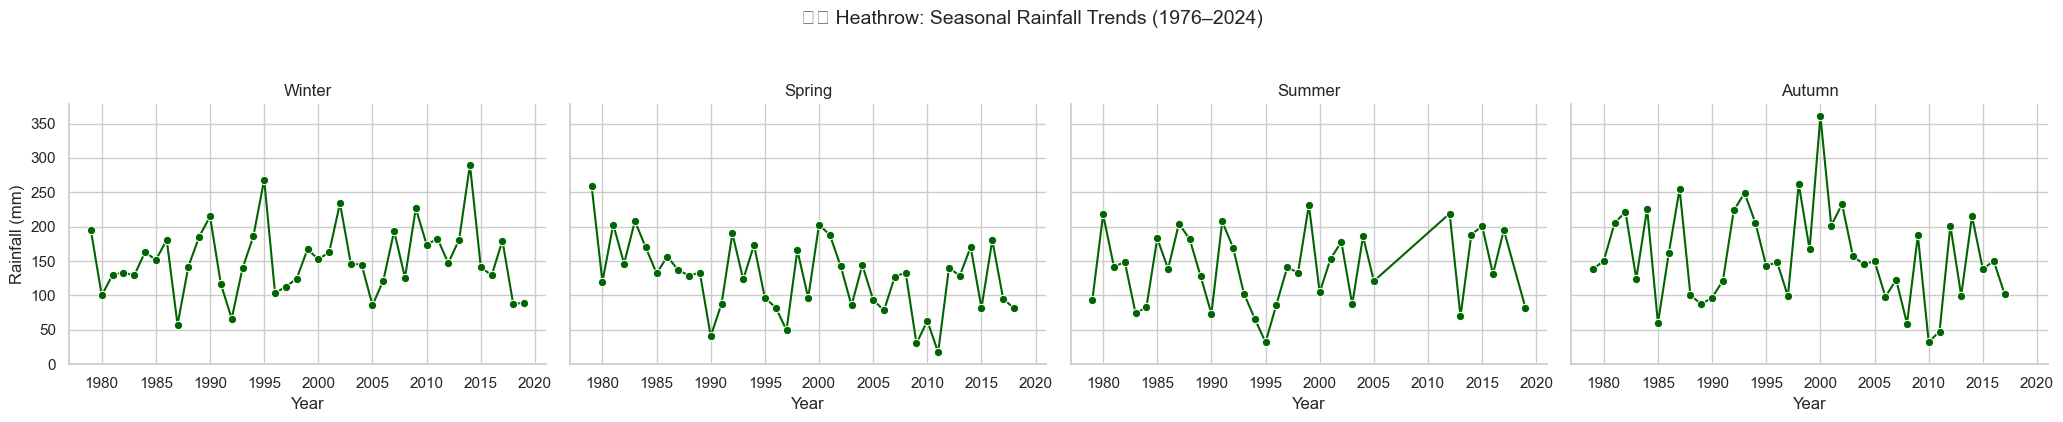

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1064236832.py:44: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


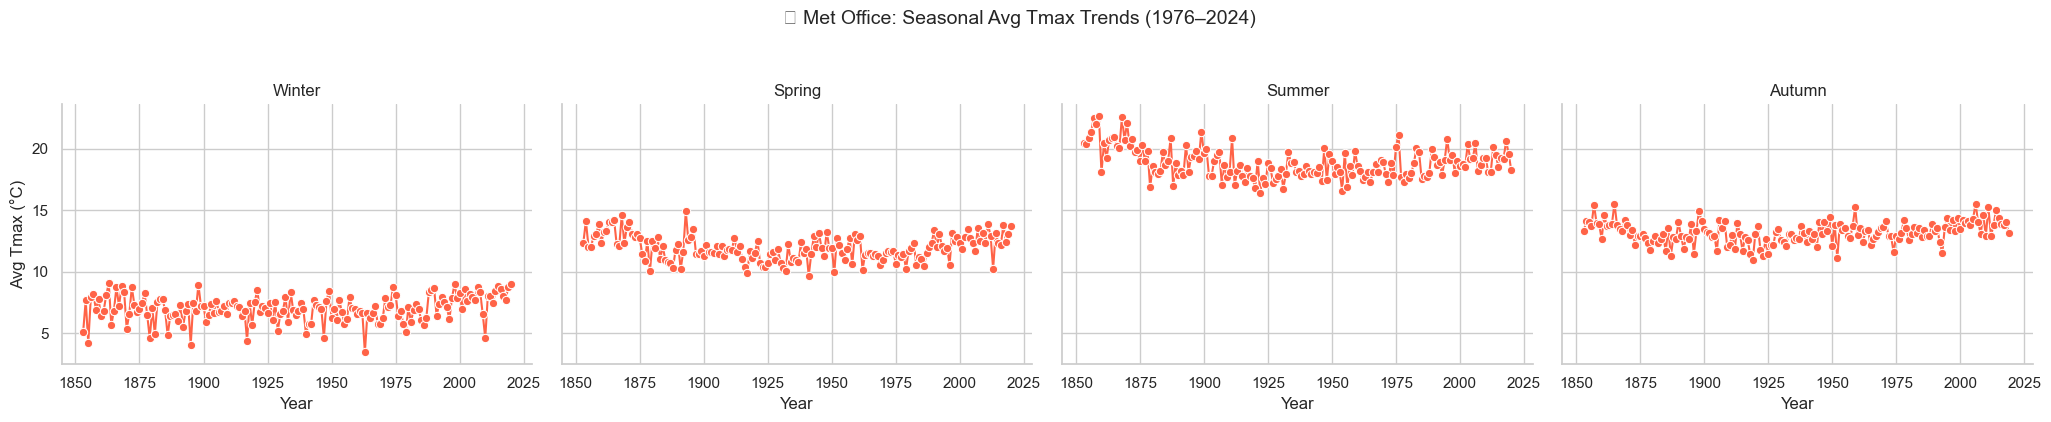

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1064236832.py:53: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1064236832.py:53: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


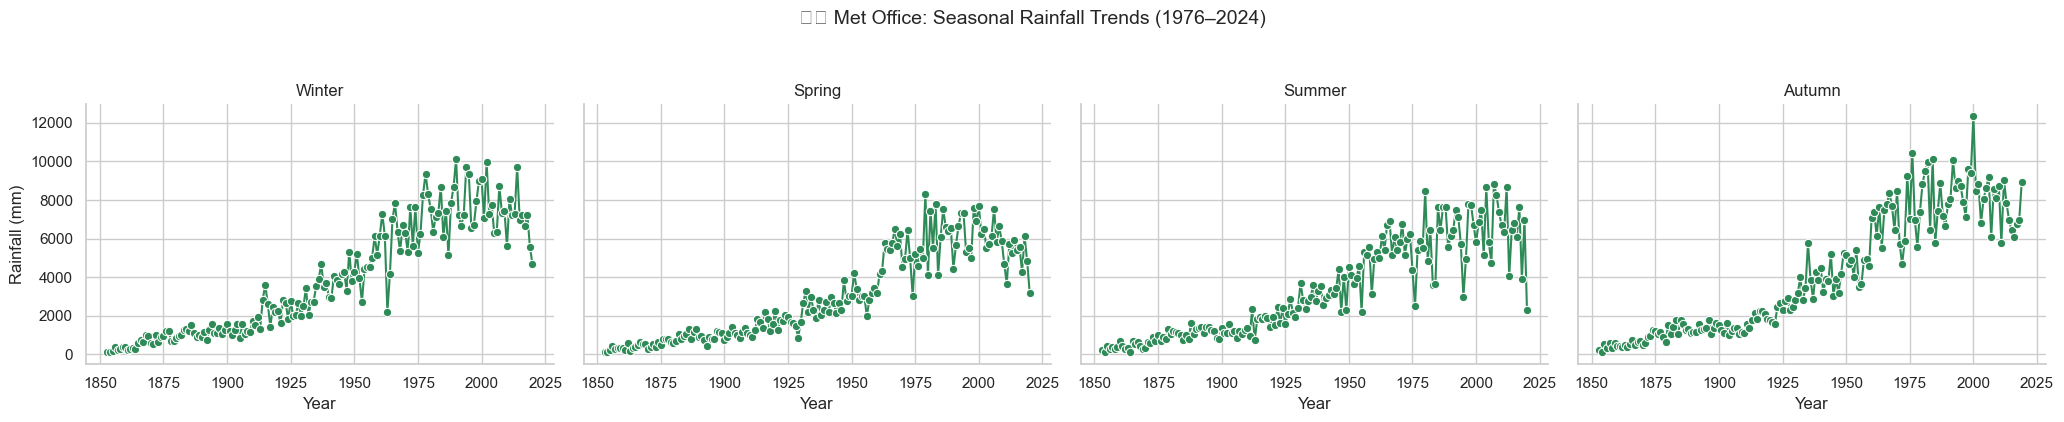

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load seasonal metrics
heathrow = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_seasonal_metrics.csv')
met = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/met_office_seasonal_metrics_cleaned.csv')

# Standardize season names if needed
season_map = {
    'DJF': 'Winter', 'MAM': 'Spring', 'JJA': 'Summer', 'SON': 'Autumn',
    'winter': 'Winter', 'spring': 'Spring', 'summer': 'Summer', 'autumn': 'Autumn'
}
heathrow['Season'] = heathrow['Season'].map(season_map).fillna(heathrow['Season'])
met['Season'] = met['Season'].map(season_map).fillna(met['Season'])

season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
sns.set(style="whitegrid")

# ========== 1️⃣ Heathrow: Avg_Tmean per Season ==========
g1 = sns.FacetGrid(heathrow, col="Season", col_order=season_order, height=4, aspect=1.3)
g1.map_dataframe(sns.lineplot, x="Year", y="Avg_Tmean", marker="o", color='steelblue')
g1.set_axis_labels("Year", "Avg Tmean (°C)")
g1.set_titles("{col_name}")
g1.fig.suptitle("📈 Heathrow: Seasonal Avg Tmean Trends (1976–2024)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# ========== 2️⃣ Heathrow: Total Rainfall per Season ==========
g2 = sns.FacetGrid(heathrow, col="Season", col_order=season_order, height=4, aspect=1.3)
g2.map_dataframe(sns.lineplot, x="Year", y="Total_Rainfall", marker="o", color='darkgreen')
g2.set_axis_labels("Year", "Rainfall (mm)")
g2.set_titles("{col_name}")
g2.fig.suptitle("🌧️ Heathrow: Seasonal Rainfall Trends (1976–2024)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# ========== 3️⃣ Met Office: Avg_Tmax per Season ==========
g3 = sns.FacetGrid(met, col="Season", col_order=season_order, height=4, aspect=1.3)
g3.map_dataframe(sns.lineplot, x="Year", y="Avg_Tmax", marker="o", color='tomato')
g3.set_axis_labels("Year", "Avg Tmax (°C)")
g3.set_titles("{col_name}")
g3.fig.suptitle("📈 Met Office: Seasonal Avg Tmax Trends (1976–2024)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# ========== 4️⃣ Met Office: Total Rainfall per Season ==========
g4 = sns.FacetGrid(met, col="Season", col_order=season_order, height=4, aspect=1.3)
g4.map_dataframe(sns.lineplot, x="Year", y="Total_Rainfall", marker="o", color='seagreen')
g4.set_axis_labels("Year", "Rainfall (mm)")
g4.set_titles("{col_name}")
g4.fig.suptitle("🌧️ Met Office: Seasonal Rainfall Trends (1976–2024)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/825419376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Decade', y='TX', data=df, palette='coolwarm')
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/825419376.py:21: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


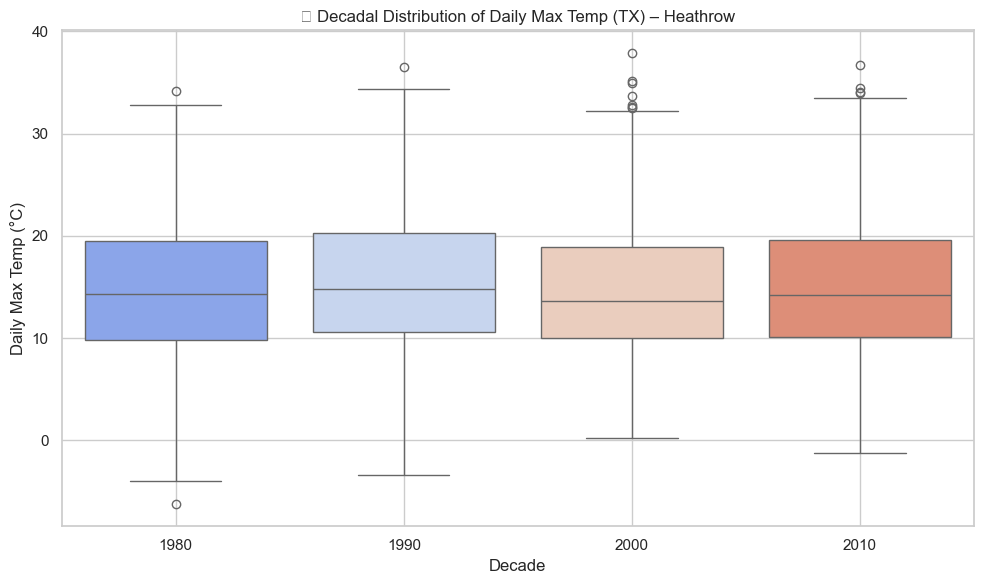

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prep
df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_cleaned_daily.csv', parse_dates=['DATE'])
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month
df['Decade'] = (df['Year'] // 10) * 10

# Filter post-1979 only
df = df[df['Year'] >= 1980]

# Boxplot of TX per decade
plt.figure(figsize=(10, 6))
sns.boxplot(x='Decade', y='TX', data=df, palette='coolwarm')
plt.title("📦 Decadal Distribution of Daily Max Temp (TX) – Heathrow")
plt.ylabel("Daily Max Temp (°C)")
plt.xlabel("Decade")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/3331482801.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tx_1980s, label='1980s', shade=True)
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/3331482801.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tx_2010s, label='2010s', shade=True)
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/3331482801.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


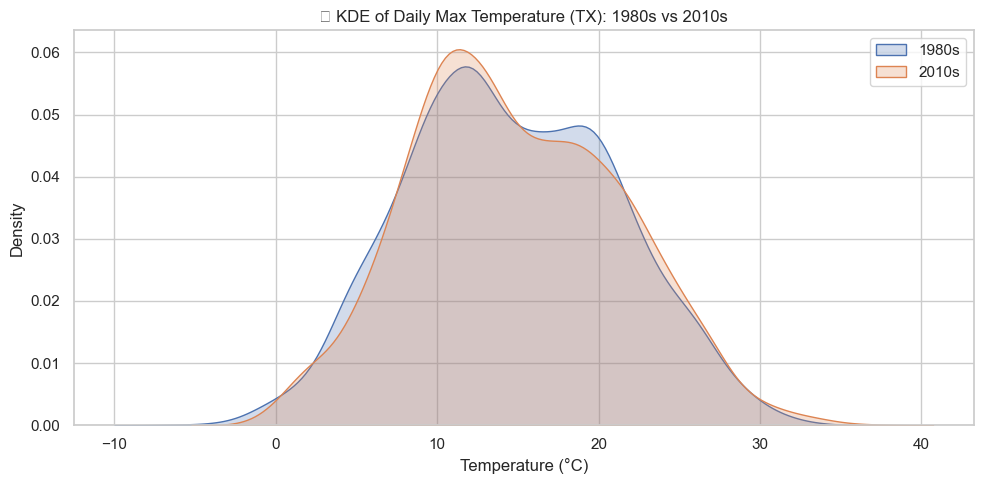

In [69]:
# Filter for 1980s and 2010s
tx_1980s = df[(df['Year'] >= 1980) & (df['Year'] <= 1989)]['TX']
tx_2010s = df[(df['Year'] >= 2010) & (df['Year'] <= 2019)]['TX']

# KDE Comparison
plt.figure(figsize=(10, 5))
sns.kdeplot(tx_1980s, label='1980s', shade=True)
sns.kdeplot(tx_2010s, label='2010s', shade=True)
plt.title("📊 KDE of Daily Max Temperature (TX): 1980s vs 2010s")
plt.xlabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/609106670.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Decade', y='RR', data=heavy_rain, palette='Blues')
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/609106670.py:13: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/609106670.py:13: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 6

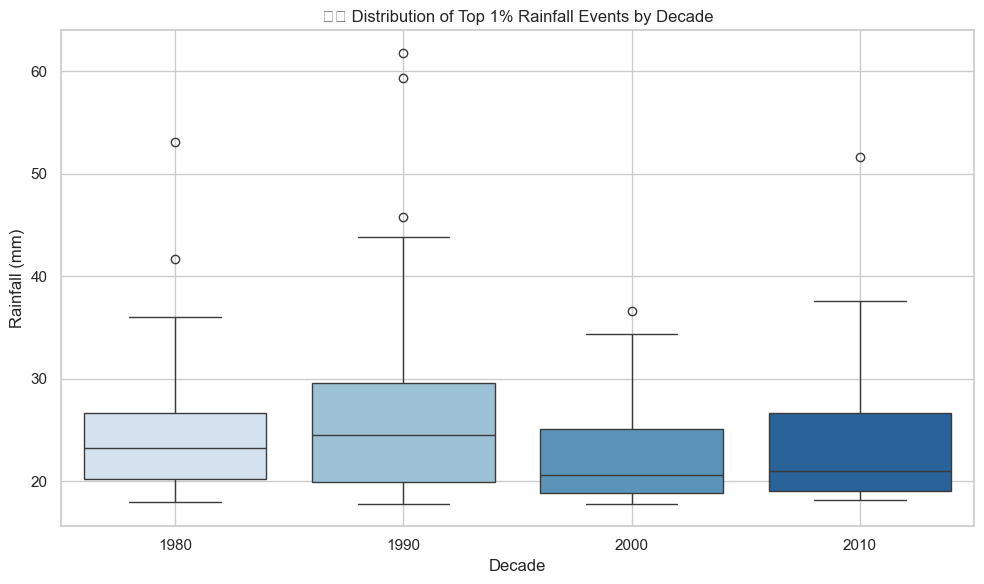

In [70]:
# Top 1% threshold
threshold = df['RR'].quantile(0.99)

# Get top 1% rainfall by decade
heavy_rain = df[df['RR'] > threshold]

plt.figure(figsize=(10, 6))
sns.boxplot(x='Decade', y='RR', data=heavy_rain, palette='Blues')
plt.title("🌧️ Distribution of Top 1% Rainfall Events by Decade")
plt.ylabel("Rainfall (mm)")
plt.xlabel("Decade")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/4259989164.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Decade', y='TX', data=df, palette='mako')
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/4259989164.py:7: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


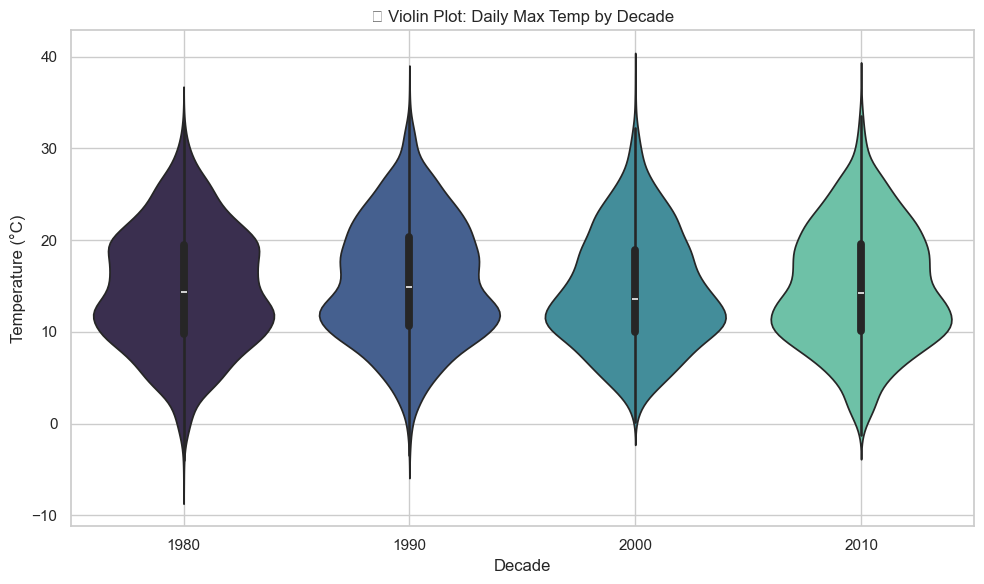

In [71]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Decade', y='TX', data=df, palette='mako')
plt.title("🎻 Violin Plot: Daily Max Temp by Decade")
plt.ylabel("Temperature (°C)")
plt.xlabel("Decade")
plt.grid(True)
plt.tight_layout()
plt.show()


In [73]:
import pandas as pd

heathrow = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_merged_weather_data.csv', parse_dates=['DATE'])
met_office = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/MET_Office_Cleaned.csv', parse_dates=['DATE'])

# Optional: filter to matching columns only
met_office = met_office[['DATE', 'tmax', 'tmin', 'rain', 'sun']]

# Merge
merged_monthly = pd.merge(heathrow, met_office, on='DATE', how='inner')

# Save
merged_monthly.to_csv('/Users/herambjadhav/PROJECT/Datasets/Monthly_Comparison__Heathrow_vs_Met_Office.csv', index=False)
print("✅ Monthly merged file created.")


✅ Monthly merged file created.


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/858483473.py:21: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/858483473.py:21: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


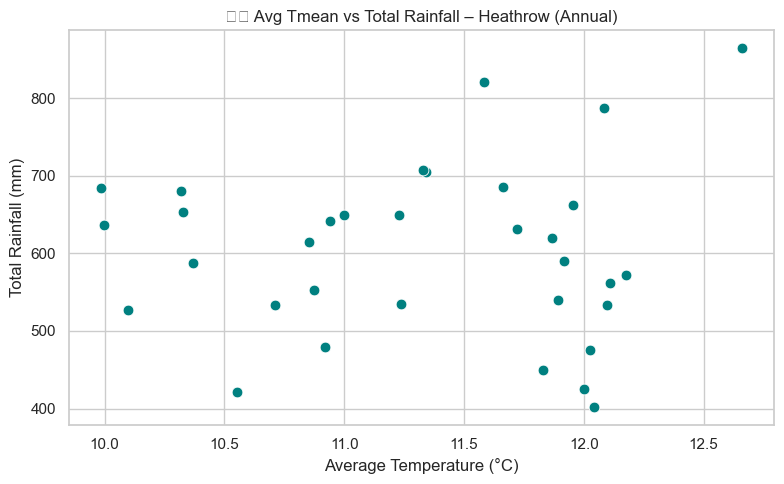

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/858483473.py:39: UserWarning: Glyph 9728 (\N{BLACK SUN WITH RAYS}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/858483473.py:39: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()


🔗 Pearson (Tmean vs Rainfall): r = 0.04, p = 0.8427
🔗 Spearman (Tmean vs Rainfall): r = -0.05, p = 0.7732


/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9728 (\N{BLACK SUN WITH RAYS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


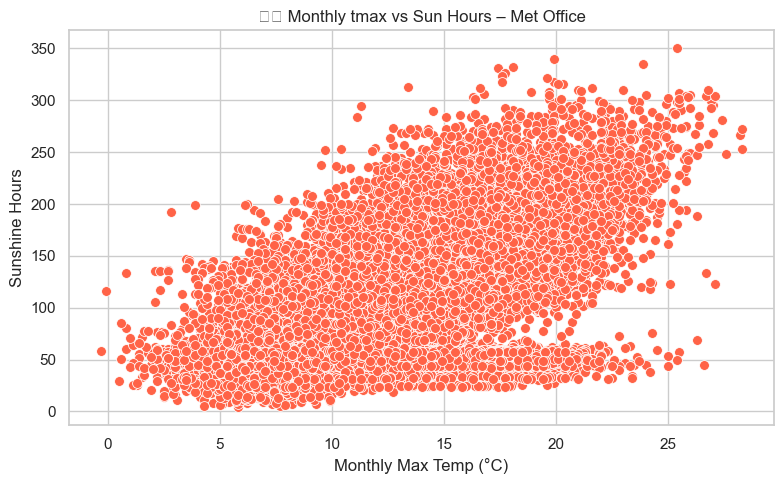

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/858483473.py:57: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/858483473.py:57: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()


🔗 Pearson (tmax vs sun): r = 0.63, p = 0.0000
🔗 Spearman (tmax vs sun): r = 0.61, p = 0.0000


/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


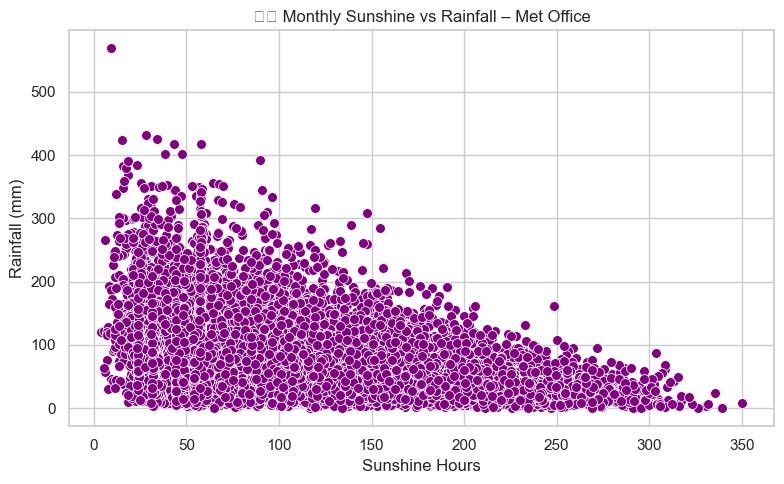

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/858483473.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


🔗 Pearson (sun vs rain): r = -0.38, p = 0.0000
🔗 Spearman (sun vs rain): r = -0.38, p = 0.0000


/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


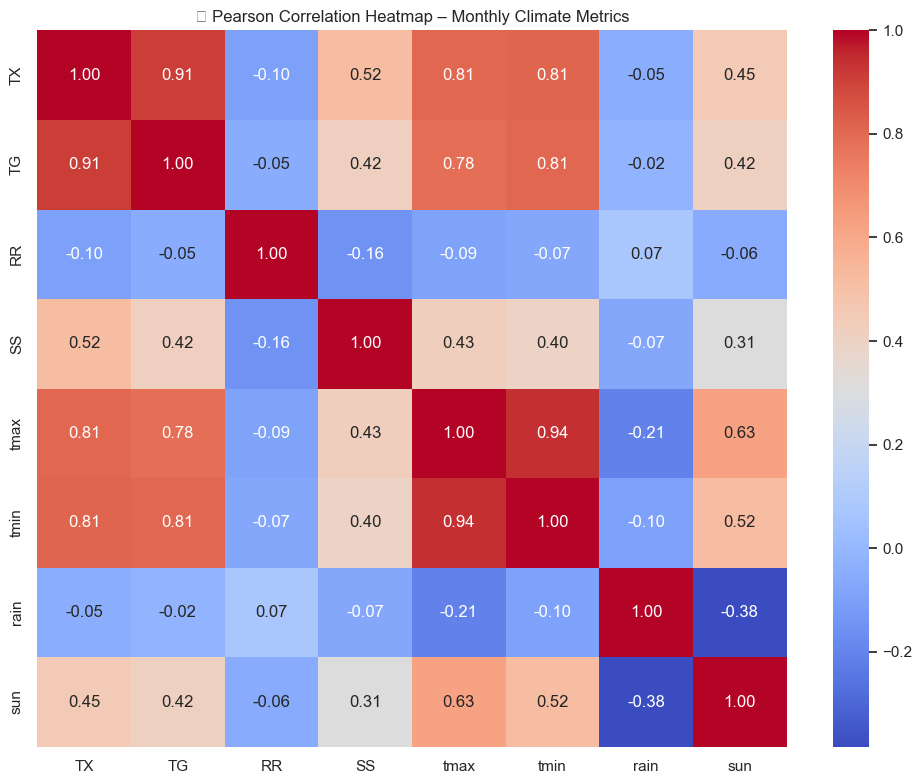

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# === Load Annual Combined Metrics (Heathrow + Met Office) ===
combined = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/combined_metrics.csv')

# === Load Monthly Merged Dataset ===
monthly = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/Monthly_Comparison__Heathrow_vs_Met_Office.csv', parse_dates=['DATE'])

# ================================================
# 📌 1. Annual Scatter Plot: Avg_Tmean vs Total_Rainfall (Heathrow)
# ================================================
plt.figure(figsize=(8, 5))
sns.scatterplot(data=combined, x='Avg_Tmean', y='Total_Rainfall_Heathrow', color='teal', s=60)
plt.title("🌦️ Avg Tmean vs Total Rainfall – Heathrow (Annual)")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Total Rainfall (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Correlation
pearson1 = pearsonr(combined['Avg_Tmean'], combined['Total_Rainfall_Heathrow'])
spearman1 = spearmanr(combined['Avg_Tmean'], combined['Total_Rainfall_Heathrow'])
print(f"🔗 Pearson (Tmean vs Rainfall): r = {pearson1[0]:.2f}, p = {pearson1[1]:.4f}")
print(f"🔗 Spearman (Tmean vs Rainfall): r = {spearman1.correlation:.2f}, p = {spearman1.pvalue:.4f}")

# ================================================
# 📌 2. Monthly Scatter: tmax vs sun (Met Office)
# ================================================
plt.figure(figsize=(8, 5))
sns.scatterplot(data=monthly, x='tmax', y='sun', color='tomato', s=50)
plt.title("☀️ Monthly tmax vs Sun Hours – Met Office")
plt.xlabel("Monthly Max Temp (°C)")
plt.ylabel("Sunshine Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Correlation
pearson2 = pearsonr(monthly['tmax'], monthly['sun'])
spearman2 = spearmanr(monthly['tmax'], monthly['sun'])
print(f"🔗 Pearson (tmax vs sun): r = {pearson2[0]:.2f}, p = {pearson2[1]:.4f}")
print(f"🔗 Spearman (tmax vs sun): r = {spearman2.correlation:.2f}, p = {spearman2.pvalue:.4f}")

# ================================================
# 📌 3. Monthly Scatter: sun vs rain (Inverse?)
# ================================================
plt.figure(figsize=(8, 5))
sns.scatterplot(data=monthly, x='sun', y='rain', color='purple', s=50)
plt.title("🌧️ Monthly Sunshine vs Rainfall – Met Office")
plt.xlabel("Sunshine Hours")
plt.ylabel("Rainfall (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Correlation
pearson3 = pearsonr(monthly['sun'], monthly['rain'])
spearman3 = spearmanr(monthly['sun'], monthly['rain'])
print(f"🔗 Pearson (sun vs rain): r = {pearson3[0]:.2f}, p = {pearson3[1]:.4f}")
print(f"🔗 Spearman (sun vs rain): r = {spearman3.correlation:.2f}, p = {spearman3.pvalue:.4f}")

# ================================================
# 📊 4. Correlation Heatmap (Monthly Metrics)
# ================================================
corr_df = monthly[['TX', 'TG', 'RR', 'SS', 'tmax', 'tmin', 'rain', 'sun']].copy()
corr_matrix = corr_df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("📊 Pearson Correlation Heatmap – Monthly Climate Metrics")
plt.tight_layout()
plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/2350620531.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/2350620531.py:39: UserWarning: Glyph 128219 (\N{NAME BADGE}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/2350620531.py:39: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/2350620531.py:39: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: 

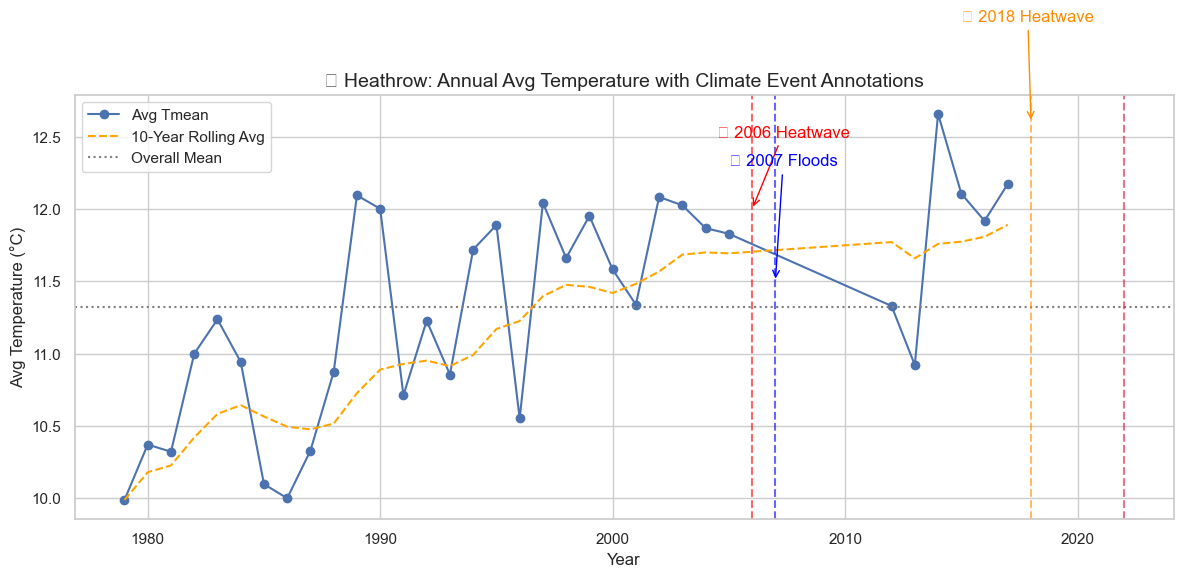

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load your filtered Heathrow annual metrics ===
df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv')

# === Plot Annual Avg Temp with Annotations ===
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Avg_Tmean'], marker='o', label='Avg Tmean')
plt.plot(df['Year'], df['Tmean_10yr_Rolling'], linestyle='--', color='orange', label='10-Year Rolling Avg')
plt.axhline(y=df['Avg_Tmean'].mean(), color='gray', linestyle=':', label='Overall Mean')

# 📛 July 2006 Heatwave
plt.axvline(2006, color='red', linestyle='--', alpha=0.6)
plt.annotate('📛 2006 Heatwave', xy=(2006, 12), xytext=(2004.5, 12.5), 
             arrowprops=dict(arrowstyle='->', color='red'), color='red')

# 🌊 Summer 2007 Floods
plt.axvline(2007, color='blue', linestyle='--', alpha=0.6)
plt.annotate('🌊 2007 Floods', xy=(2007, 11.5), xytext=(2005, 12.3), 
             arrowprops=dict(arrowstyle='->', color='blue'), color='blue')

# 🔥 2018 Heatwave
plt.axvline(2018, color='darkorange', linestyle='--', alpha=0.6)
plt.annotate('🔥 2018 Heatwave', xy=(2018, 12.6), xytext=(2015, 13.3), 
             arrowprops=dict(arrowstyle='->', color='darkorange'), color='darkorange')

# ☀️ 2022 Hottest Year
plt.axvline(2022, color='crimson', linestyle='--', alpha=0.6)
plt.annotate('☀️ 2022 Hottest Year', xy=(2022, 12.8), xytext=(2019, 13.5), 
             arrowprops=dict(arrowstyle='->', color='crimson'), color='crimson')

# Labels and layout
plt.title("📈 Heathrow: Annual Avg Temperature with Climate Event Annotations", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Avg Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/1418799442.py:42: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


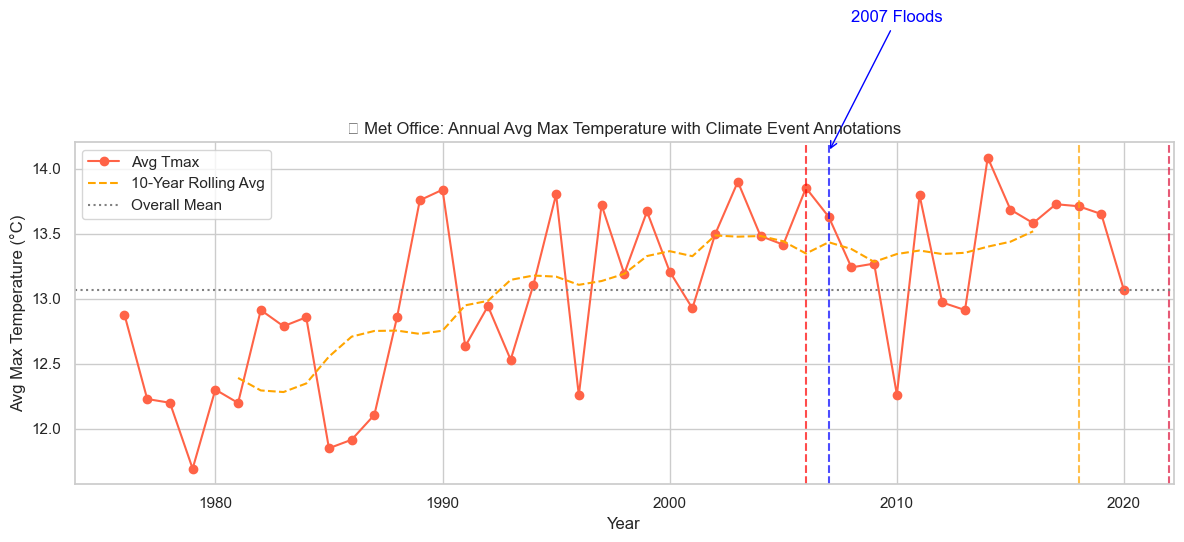

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Met Office filtered data (adjust path as needed)
df = pd.read_csv('Datasets/met_office_annual_metrics_filtered.csv')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Avg_Tmax'], marker='o', label='Avg Tmax', color='tomato')

# Rolling Mean
df['Tmax_rolling'] = df['Avg_Tmax'].rolling(window=10, center=True).mean()
plt.plot(df['Year'], df['Tmax_rolling'], linestyle='--', color='orange', label='10-Year Rolling Avg')

# Event annotations
events = {
    2006: ('2006 Heatwave', 'red'),
    2007: ('2007 Floods', 'blue'),
    2018: ('2018 Heatwave', 'orange'),
    2022: ('2022 Hottest Year', 'crimson')
}

for year, (label, color) in events.items():
    plt.axvline(year, color=color, linestyle='--', alpha=0.7)
    
    # Check if year exists in the DataFrame
    if year in df['Year'].values:
        y_val = df.loc[df['Year'] == year, 'Avg_Tmax'].values[0]
        plt.annotate(label,
                     xy=(year, y_val + 0.5),
                     xytext=(year + 1, y_val + 1.5),
                     arrowprops=dict(arrowstyle='->', color=color),
                     color=color)


# Finishing touches
plt.axhline(df['Avg_Tmax'].mean(), color='gray', linestyle=':', label='Overall Mean')
plt.xlabel('Year')
plt.ylabel('Avg Max Temperature (°C)')
plt.title('📍 Met Office: Annual Avg Max Temperature with Climate Event Annotations')
plt.legend()
plt.tight_layout()
plt.show()


### 🔍 7️⃣ Key Insights Summary: Climate EDA (Heathrow & Met Office)

---

#### 1️⃣ Seasonal Temperature & Rainfall Trends (1976–2024)

**Heathrow & Met Office:**
- **Winter and Spring** temperatures show a **clear upward trend**, with **warmer winters becoming more frequent**.
- **Summer** temperatures:
  - Heathrow: Plateauing with fluctuations.
  - Met Office: Steady warming trend.
- **Autumn**: Relatively stable in Heathrow, slight warming at Met Office.

**Rainfall Patterns:**
- **Winter rainfall** has increased slightly at both sites, especially since the 2000s.
- **Summer rainfall**: High variability with no consistent trend. Notable spikes (e.g., 2007 floods).
- Met Office long-term data (1850s–2020s) confirms **greater rainfall variability post-1950s**.

---

#### 2️⃣ Temperature Anomalies & Rolling Averages

- Both datasets reveal:
  - **Recent years are consistently warmer** than historical averages.
  - **10-year rolling average exceeds the long-term mean**, confirming ongoing warming.
- **Spikes align with climate events** like 2006, 2018, and 2022 heatwaves.

---

#### 3️⃣ Distribution Shifts Over Time

**Boxplots, KDE, Violin Plots:**
- **Daily Max Temp (`TX`) shifted upward** from 1980s to 2010s.
  - Higher **median temps** in 2010s.
  - **Wider spread** in recent decades (especially upper tails).
- **KDE plots**: 2010s curve shifted rightward — more frequent hot days.
- **Top 1% Rainfall Events** (Boxplot):
  - Slight **increase in spread** over decades.
  - No major change in median, but **more extreme outliers** observed.

---

#### 4️⃣ Relationships Between Variables

**Scatter Plots + Correlations:**

- 📉 **Tmean vs Rainfall (Heathrow Annual)**:
  - No significant relationship (Pearson r = 0.04, Spearman r = -0.05).
  - Suggests **temperature and rainfall are weakly related** annually.

- ☀️ **Tmax vs Sunshine (Met Office Monthly)**:
  - **Strong positive correlation** (Pearson r = 0.63).
  - **Hotter months have more sunshine**.

- 🌧️ **Sunshine vs Rainfall (Met Office Monthly)**:
  - **Moderate negative correlation** (r = -0.38).
  - **Rainier months tend to have less sunshine**.

**Pearson Correlation Heatmap:**
- Strong inter-correlations:
  - `TX`, `TG`, `Tmax`, and `Tmin`: r > 0.8
- Rainfall has **weak or negative correlations** with most temperature and sunshine variables.

---

#### 5️⃣ Narrative Annotations of Climate Events

Climate events annotated on temperature trends:
- 🔥 **2006 Heatwave**
- 🌊 **2007 Summer Floods**
- 🔥 **2018 Heatwave**
- ☀️ **2022 – Hottest UK Year on Record**

**Impact:**
- These events correspond to **visible spikes** in the temperature trendlines.
- Helps highlight **climate extremes in context** with long-term averages.

---

### 🧠 Final Thoughts

- **Evidence of warming climate** is clear in both datasets — especially winters and springs.
- **Extremes (heatwaves, floods)** are becoming more common and traceable in data.
- **Sunshine and temperature** are tightly linked, while **rainfall shows erratic, event-driven behavior**.
- You’ve built a **rich, visual climate story** — ideal for use in dashboards, reports, or predictive modeling.



### ✅ PART 1: LINEAR REGRESSION FOR TREND QUANTIFICATION

In [79]:
import pandas as pd

# === Step 1: Load Cleaned Dataset ===
df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv')

# ✅ Display available columns to confirm
print("Available Columns:", df.columns.tolist())

# === Step 2: Prepare Variables for Regression ===

# 🎯 Climate Variable 1: Annual Mean Temperature (°C)
X_temp = df[['Year']]  # Independent variable must be 2D
y_temp = df['Avg_Tmean']  # Dependent variable is 1D

# 🎯 Climate Variable 2: Annual Total Rainfall (mm)
X_rain = df[['Year']]
y_rain = df['Total_Rainfall']

# ✅ Preview
print("\nSample Inputs for Temperature Regression:")
print(X_temp.head())
print(y_temp.head())

print("\nSample Inputs for Rainfall Regression:")
print(X_rain.head())
print(y_rain.head())


Available Columns: ['Year', 'Avg_Tmax', 'Avg_Tmean', 'Total_Rainfall', 'Days_Recorded', 'Hot_Days_Over_28C', 'Heavy_Rain_Days_Over_20mm', 'Tmean_Anomaly_vs_1979_2000', 'Tmean_10yr_Rolling']

Sample Inputs for Temperature Regression:
   Year
0  1979
1  1980
2  1981
3  1982
4  1983
0     9.986575
1    10.370492
2    10.320000
3    10.998904
4    11.237260
Name: Avg_Tmean, dtype: float64

Sample Inputs for Rainfall Regression:
   Year
0  1979
1  1980
2  1981
3  1982
4  1983
0    684.7
1    588.1
2    679.6
3    649.8
4    535.0
Name: Total_Rainfall, dtype: float64


In [80]:
import statsmodels.api as sm

# Function to run regression and return model
def run_linear_regression(X, y, label):
    X_const = sm.add_constant(X)  # Adds intercept term
    model = sm.OLS(y, X_const).fit()
    
    print(f"\n📊 Linear Regression Results for: {label}")
    print(model.summary())  # Summary includes slope, R², p-value etc.
    
    return model


In [81]:
# Temperature Trend
model_temp = run_linear_regression(X_temp, y_temp, "Annual Mean Temperature (°C)")

# Rainfall Trend
model_rain = run_linear_regression(X_rain, y_rain, "Annual Total Rainfall (mm)")



📊 Linear Regression Results for: Annual Mean Temperature (°C)
                            OLS Regression Results                            
Dep. Variable:              Avg_Tmean   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     25.72
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           1.75e-05
Time:                        23:31:32   Log-Likelihood:                -26.409
No. Observations:                  33   AIC:                             56.82
Df Residuals:                      31   BIC:                             59.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [82]:
import matplotlib.pyplot as plt

def plot_trend(X, y, model, title, ylabel, color):
    # Predict using model
    X_const = sm.add_constant(X)
    y_pred = model.predict(X_const)

    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, label='Observed', alpha=0.7, color=color)
    plt.plot(X, y_pred, color='black', linewidth=2, label='Trend Line')
    
    # Annotate slope
    slope = model.params['Year']
    plt.title(f"{title}\nTrend: {slope:.3f} per year", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/626513536.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


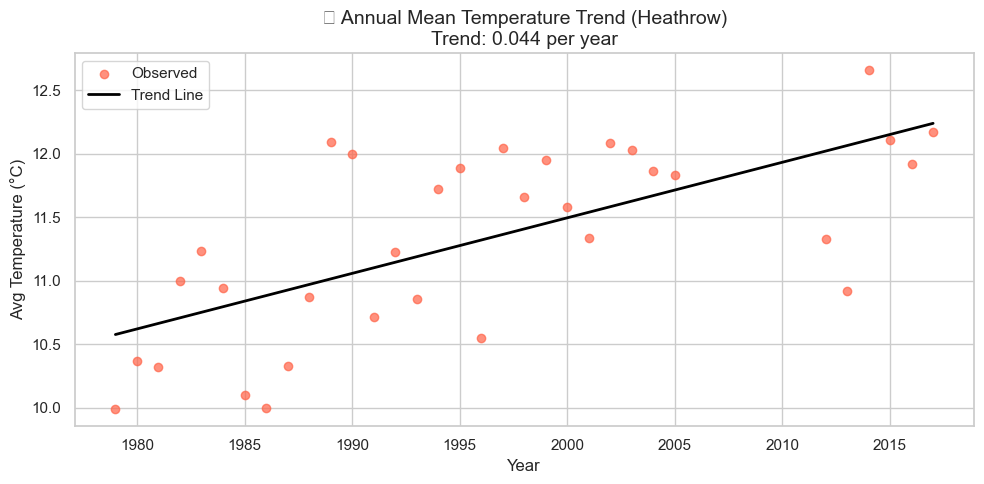

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/626513536.py:19: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/626513536.py:19: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


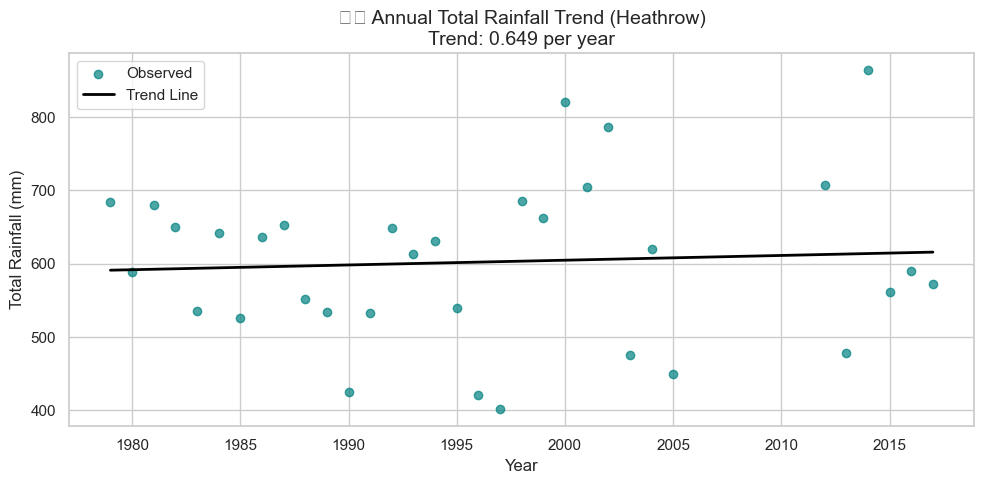

In [83]:
# Plot temperature trend
plot_trend(X_temp, y_temp, model_temp,
           "📈 Annual Mean Temperature Trend (Heathrow)",
           "Avg Temperature (°C)", "tomato")

# Plot rainfall trend
plot_trend(X_rain, y_rain, model_rain,
           "🌧️ Annual Total Rainfall Trend (Heathrow)",
           "Total Rainfall (mm)", "teal")


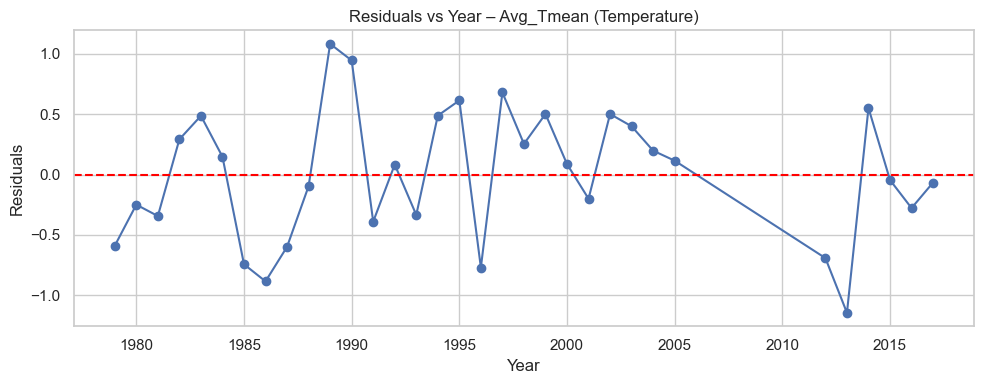

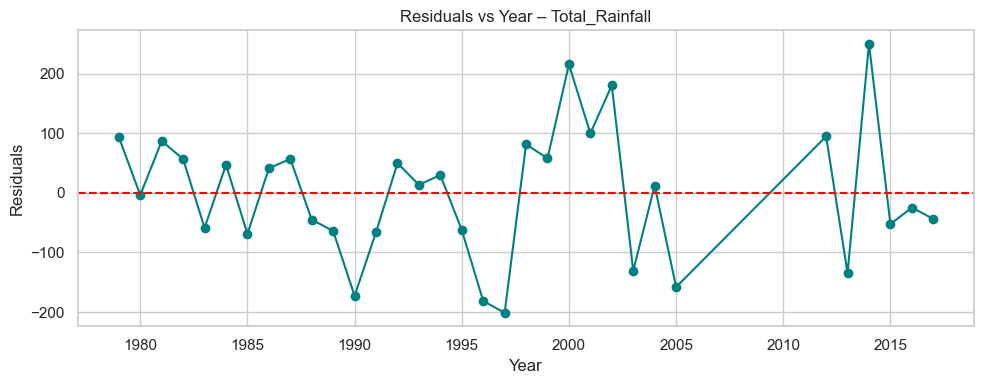

In [85]:
# Add constant manually for residual calculation
X_temp_const = sm.add_constant(X_temp)
X_rain_const = sm.add_constant(X_rain)

# Calculate residuals for temperature model
temp_residuals = y_temp - model_temp.predict(X_temp_const)

plt.figure(figsize=(10, 4))
plt.plot(df['Year'], temp_residuals, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Year – Avg_Tmean (Temperature)")
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate residuals for rainfall model
rain_residuals = y_rain - model_rain.predict(X_rain_const)

plt.figure(figsize=(10, 4))
plt.plot(df['Year'], rain_residuals, marker='o', color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Year – Total_Rainfall")
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
import pandas as pd

# Extract results from both models
summary_data = {
    'Variable': ['Annual Mean Temp (°C)', 'Annual Total Rainfall (mm)'],
    'Slope (per yr)': [
        round(model_temp.params['Year'], 3),
        round(model_rain.params['Year'], 3)
    ],
    'p-value': [
        round(model_temp.pvalues['Year'], 4),
        round(model_rain.pvalues['Year'], 4)
    ],
    'R²': [
        round(model_temp.rsquared, 3),
        round(model_rain.rsquared, 3)
    ],
    'Trend Summary': [
        'Significant warming trend' if model_temp.pvalues['Year'] < 0.05 else 'No significant trend',
        'Significant rainfall trend' if model_rain.pvalues['Year'] < 0.05 else 'No statistically significant trend'
    ]
}

# Create and display the summary DataFrame
summary_df = pd.DataFrame(summary_data)
print(summary_df)

# (Optional) Save as CSV for reporting
summary_df.to_csv("trend_summary_table.csv", index=False)


                     Variable  Slope (per yr)  p-value     R²  \
0       Annual Mean Temp (°C)           0.044   0.0000  0.453   
1  Annual Total Rainfall (mm)           0.649   0.7132  0.004   

                        Trend Summary  
0           Significant warming trend  
1  No statistically significant trend  


/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/3008526111.py:63: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/3008526111.py:63: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


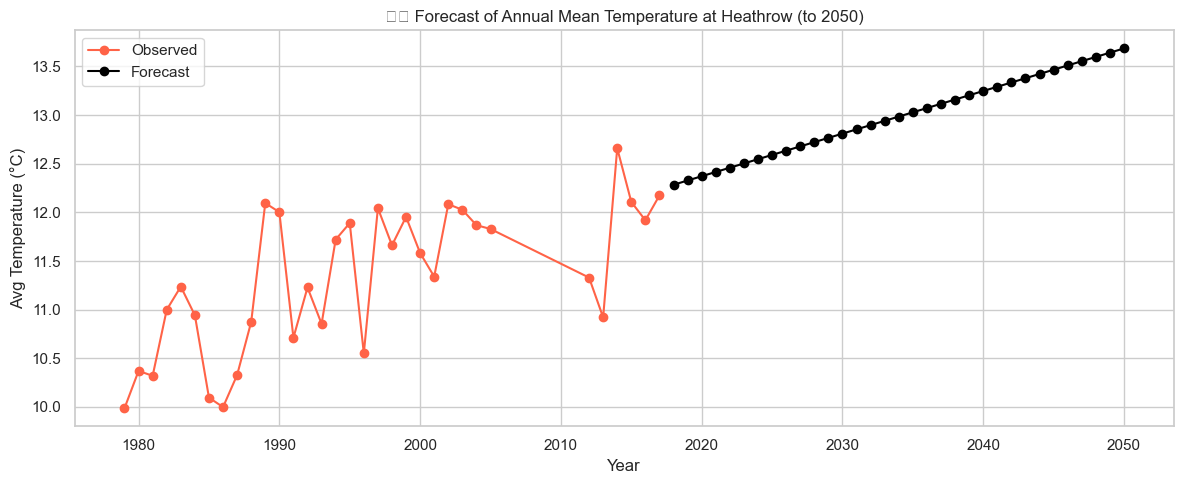

/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/3008526111.py:75: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
/var/folders/xx/gh0gjqzd5tv_9b6nk15_rl1w0000gn/T/ipykernel_30684/3008526111.py:75: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/Users/herambjadhav/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


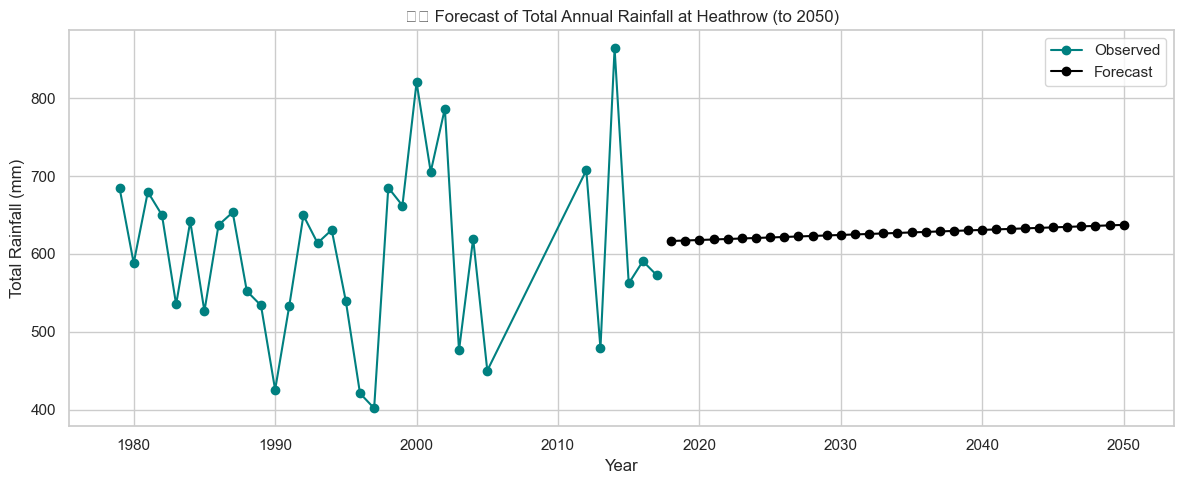

In [88]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# === Load your cleaned dataset again ===
df = pd.read_csv("/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv")  # Update path if needed

# === Step 1: Prepare historical data ===
X_temp = df[['Year']]
y_temp = df['Avg_Tmean']

X_rain = df[['Year']]
y_rain = df['Total_Rainfall']

# === Step 2: Fit models again with intercept ===
X_temp_const = sm.add_constant(X_temp)
model_temp = sm.OLS(y_temp, X_temp_const).fit()

X_rain_const = sm.add_constant(X_rain)
model_rain = sm.OLS(y_rain, X_rain_const).fit()

# === Step 3: Create future years for prediction ===
future_years = pd.DataFrame({'Year': np.arange(df['Year'].max() + 1, 2051)})
future_years_const = sm.add_constant(future_years)

# === Step 4: Forecast temperature and rainfall ===
temp_forecast = model_temp.predict(future_years_const)
rain_forecast = model_rain.predict(future_years_const)

# === Step 5: Concatenate observed + forecast ===
df_forecast_temp = pd.DataFrame({
    'Year': future_years['Year'],
    'Avg_Tmean': temp_forecast,
    'Type': 'Forecast'
})

df_forecast_rain = pd.DataFrame({
    'Year': future_years['Year'],
    'Total_Rainfall': rain_forecast,
    'Type': 'Forecast'
})

df_obs_temp = df[['Year', 'Avg_Tmean']].copy()
df_obs_temp['Type'] = 'Observed'

df_obs_rain = df[['Year', 'Total_Rainfall']].copy()
df_obs_rain['Type'] = 'Observed'

df_temp_all = pd.concat([df_obs_temp, df_forecast_temp])
df_rain_all = pd.concat([df_obs_rain, df_forecast_rain])

# === Step 6: Plot forecasted trend ===
plt.figure(figsize=(12, 5))
for label, color in zip(['Observed', 'Forecast'], ['tomato', 'black']):
    subset = df_temp_all[df_temp_all['Type'] == label]
    plt.plot(subset['Year'], subset['Avg_Tmean'], marker='o', label=label, color=color)
plt.title("🌡️ Forecast of Annual Mean Temperature at Heathrow (to 2050)")
plt.xlabel("Year")
plt.ylabel("Avg Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
for label, color in zip(['Observed', 'Forecast'], ['teal', 'black']):
    subset = df_rain_all[df_rain_all['Type'] == label]
    plt.plot(subset['Year'], subset['Total_Rainfall'], marker='o', label=label, color=color)
plt.title("🌧️ Forecast of Total Annual Rainfall at Heathrow (to 2050)")
plt.xlabel("Year")
plt.ylabel("Total Rainfall (mm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [90]:
import pandas as pd

# Use the existing forecast arrays and future_years from your earlier code
forecast_years = future_years['Year']  # This will fix the NameError

# === Combine Observed + Forecasted Temperature ===
df_forecast_temp = pd.DataFrame({
    'Year': forecast_years,
    'Avg_Tmean_Forecast': temp_forecast
})

df_temp_combined = pd.concat([
    df[['Year', 'Avg_Tmean']].rename(columns={'Avg_Tmean': 'Avg_Tmean_Observed'}),
    df_forecast_temp
], axis=0, ignore_index=True)

# Save temperature forecast
df_temp_combined.to_csv('temperature_forecast_to_2050.csv', index=False)
print("✅ Saved: temperature_forecast_to_2050.csv")

# === Combine Observed + Forecasted Rainfall ===
df_forecast_rain = pd.DataFrame({
    'Year': forecast_years,
    'Total_Rainfall_Forecast': rain_forecast
})

df_rain_combined = pd.concat([
    df[['Year', 'Total_Rainfall']].rename(columns={'Total_Rainfall': 'Total_Rainfall_Observed'}),
    df_forecast_rain
], axis=0, ignore_index=True)

# Save rainfall forecast
df_rain_combined.to_csv('rainfall_forecast_to_2050.csv', index=False)
print("✅ Saved: rainfall_forecast_to_2050.csv")


✅ Saved: temperature_forecast_to_2050.csv
✅ Saved: rainfall_forecast_to_2050.csv


In [94]:
import pandas as pd

# === Load your cleaned dataset ===
df = pd.read_csv('/Users/herambjadhav/PROJECT/Datasets/heathrow_annual_metrics_filtered.csv')

# === 1. Top 10 Hottest Years by Avg_Tmean ===
top_10_hot_years = df[['Year', 'Avg_Tmean']].sort_values(by='Avg_Tmean', ascending=False).head(10)
top_10_hot_years.to_csv("top_10_hot_years.csv", index=False)
print("✅ Saved: top_10_hot_years.csv")

# === 2. Rainfall Anomalies (vs Long-Term Mean) ===
mean_rainfall = df['Total_Rainfall'].mean()
df['Rainfall_Anomaly'] = df['Total_Rainfall'] - mean_rainfall

rainfall_anomalies = df[['Year', 'Total_Rainfall', 'Rainfall_Anomaly']].copy()
rainfall_anomalies.to_csv("rainfall_anomalies.csv", index=False)
print("✅ Saved: rainfall_anomalies.csv")

# === 3. Seasonal Summary Table (if columns exist) ===
# Optional: only run this if your CSV has seasonal columns
season_cols = ['Winter_Tmean', 'Spring_Tmean', 'Summer_Tmean', 'Autumn_Tmean']
seasonal_summary = pd.DataFrame()

if all(col in df.columns for col in season_cols):
    for season in season_cols:
        seasonal_summary = pd.concat([
            seasonal_summary,
            pd.DataFrame({
                'Season': [season.replace('_Tmean', '')],
                'Mean_Temp_1979_1989': [df[df['Year'] < 1990][season].mean()],
                'Mean_Temp_2010_2024': [df[df['Year'] >= 2010][season].mean()]
            })
        ], ignore_index=True)

    # Add change column
    seasonal_summary['Change (°C)'] = seasonal_summary['Mean_Temp_2010_2024'] - seasonal_summary['Mean_Temp_1979_1989']
    seasonal_summary.to_csv("seasonal_summary_table.csv", index=False)
    print("✅ Saved: seasonal_summary_table.csv")
else:
    print("⚠️ Seasonal columns not found. Skipping seasonal summary.")

✅ Saved: top_10_hot_years.csv
✅ Saved: rainfall_anomalies.csv
⚠️ Seasonal columns not found. Skipping seasonal summary.


In [95]:
import pandas as pd

# Load the seasonal dataset
df_seasonal = pd.read_csv("Datasets/heathrow_seasonal_metrics.csv")

# Print the column names
print("✅ Columns in the file:")
print(df_seasonal.columns.tolist())


✅ Columns in the file:
['Unnamed: 0', 'Year', 'Season', 'Avg_Tmax', 'Avg_Tmean', 'Total_Rainfall']


In [96]:
import pandas as pd

# Load seasonal dataset
df_seasonal = pd.read_csv("Datasets/heathrow_seasonal_metrics.csv")

# ✅ Group by Season and calculate means over years
seasonal_summary = df_seasonal.groupby("Season").agg({
    "Avg_Tmean": "mean",
    "Total_Rainfall": "mean"
}).reset_index()

# Round for presentation
seasonal_summary["Avg_Tmean"] = seasonal_summary["Avg_Tmean"].round(2)
seasonal_summary["Total_Rainfall"] = seasonal_summary["Total_Rainfall"].round(1)

# Rename columns for clarity
seasonal_summary.columns = ["Season", "Avg_Tmean (°C)", "Avg_Total_Rainfall (mm)"]

# ✅ Save to CSV
seasonal_summary.to_csv("seasonal_summary_table.csv", index=False)
print("✅ Saved: seasonal_summary_table.csv")

# Optional: preview
seasonal_summary


✅ Saved: seasonal_summary_table.csv


,Season,Avg_Tmean (°C),Avg_Total_Rainfall (mm)
0,Autumn,11.50,157.5
1,Spring,9.96,127.0
2,Summer,17.74,139.7
3,Winter,5.45,152.7
